In [17]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU, Dropout, Flatten, Dense
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization

x_train_tmp_folder_path = "C:/Hyundai GAN/hyundai_cgan_data/circular_vane_design/tmp_input_data_circular"
x_train_dsp_folder_path = "C:/Hyundai GAN/hyundai_cgan_data/circular_vane_design/dsp_input_data_circular"
y_train_folder_path = "C:/Hyundai GAN/hyundai_cgan_data/circular_vane_design/circular_vane_output"

x_tmp_elements = os.listdir(x_train_tmp_folder_path)
x_dsp_elements = os.listdir(x_train_dsp_folder_path)
y_elements = os.listdir(y_train_folder_path)

In [19]:
source = np.zeros((20,256,256,2))
target = np.zeros((20,256,256,1))

In [20]:
# DEVELOPING X_train MATRIX

def get_images(tmp_elements,disp_elements,y_elements,size):
  X= np.zeros((size,256,256,2))
  Y= np.zeros((size,256,256,1))
  for index, (tmp_element, dsp_element) in enumerate(zip(tmp_elements, disp_elements)):
      # Load images for each channel
      tmp_element_path = os.path.join(x_train_tmp_folder_path, tmp_element)
      dsp_element_path = os.path.join(x_train_dsp_folder_path, dsp_element)
      img_tmp = imread(tmp_element_path)
      img_dsp = imread(dsp_element_path)

      # Reshape images for each channel
      img_tmp = img_tmp.reshape((256,256, 1))
      img_dsp = img_dsp.reshape((256,256, 1))

      # Combine channels
      img_combined = (np.concatenate((img_tmp, img_dsp), axis=2)-0.5)/0.5

      # Assign to X_train
      X[index] = img_combined

  # DEVELOPING Y_train MATRIX
  for index,Y_train_element in enumerate(y_elements):
      element_path = os.path.join(y_train_folder_path, Y_train_element)
      img = imread(element_path)
      img = np.mean(img, axis=2)
      img = img/127.5-1
      img = img.reshape((256, 256, 1))
      Y[index] = img
  return X,Y

In [21]:
x_tmp_elements[16:] #for test_set

['tmp_cv_790_in.png',
 'tmp_cv_842_in.png',
 'tmp_cv_870_in.png',
 'tmp_cv_889_in.png']

In [22]:
x_tr,y_tr = get_images(x_tmp_elements[:16],x_dsp_elements[:16],y_elements[:16],len(x_tmp_elements[:16]))

In [23]:
x_tr.shape,y_tr.shape

((16, 256, 256, 2), (16, 256, 256, 1))

In [24]:
train_data=tf.data.Dataset.from_tensor_slices((x_tr,y_tr))
train_data=train_data.batch(1)

In [25]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float64, name=None))>

In [26]:
#used at end for testing
x_te,y_te=get_images(x_tmp_elements[16:],x_dsp_elements[16:],y_elements[16:],len(x_tmp_elements[16:]))
x_te.shape,y_te.shape

((4, 256, 256, 2), (4, 256, 256, 1))

In [27]:
def encoder_block(input,filters,batch_norm=True):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  x=tf.keras.layers.Conv2D(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input)
  if batch_norm:
    x=tf.keras.layers.BatchNormalization()(x,training=True)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  return x

def decoder_block(input,skip_con,filters,dropout=True):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  x=tf.keras.layers.Conv2DTranspose(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input)
  x=tf.keras.layers.BatchNormalization()(x,training=True)
  if dropout:
    x=tf.keras.layers.Dropout(0.5)(x,training=True)
  x=tf.keras.layers.Concatenate()([x,skip_con])
  x=tf.keras.layers.ReLU()(x)
  return x

def generator_model(input_shape=(256,256,2)):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  input=tf.keras.layers.Input(input_shape)
  e1=encoder_block(input,64,batch_norm=False)
  e2=encoder_block(e1,128)
  e3=encoder_block(e2,256)
  e4=encoder_block(e3,512)
  e5=encoder_block(e4,512)
  e6=encoder_block(e5,512)
  e7=encoder_block(e6,512)

  b=tf.keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
  #b=tf.keras.layers.BatchNormalization()(b,training=True)
  b=tf.keras.layers.ReLU()(b)

  d1=decoder_block(b,e7,512)
  d2=decoder_block(d1,e6,512)
  d3=decoder_block(d2,e5,512)
  d4=decoder_block(d3,e4,512,dropout=False)
  d5=decoder_block(d4,e3,256,dropout=False)
  d6=decoder_block(d5,e2,128,dropout=False)
  d7=decoder_block(d6,e1,64,dropout=False)

  output=tf.keras.layers.Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
  output=tf.keras.layers.Activation('tanh')(output)
  model=tf.keras.Model(input,output)
  return model

In [28]:
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(generated_output, g_output, target):
  lambda_=100

  gan_loss = loss(tf.ones_like(generated_output), generated_output)
  gan_loss = tf.cast(gan_loss,tf.float64)

  l1_loss = tf.reduce_mean(tf.abs(tf.cast(target, tf.float64) - tf.cast(g_output, tf.float64)))
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total

In [29]:
generator=generator_model()

In [30]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  2112        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d_5[0][0]']               
                                )                                                           

In [31]:
def discriminator_model(input_shape=(256,256,2)):
  init=tf.keras.initializers.RandomNormal(stddev=0.01,seed=42)
  tar_img=tf.keras.layers.Input(input_shape)
  src_img=tf.keras.layers.Input((256,256,1))
  merged=tf.keras.layers.Concatenate()([src_img,tar_img])
  x=tf.keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(merged)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2D(1,(4,4),padding='same',kernel_initializer=init)(x)
  model=tf.keras.Model([src_img,tar_img],x)
  model.summary()
  return model

def disc_loss(real_output,fake_output):
  real_loss=loss(tf.ones_like(real_output),real_output)
  fake_loss=loss(tf.zeros_like(fake_output),fake_output)
  return real_loss+fake_loss

In [32]:
discriminator=discriminator_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 256, 256, 3)  0           ['input_5[0][0]',                
                                                                  'input_4[0][0]']          

In [33]:
gen_opt=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
disc_opt=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)

In [34]:
def compare_images(input_test,target,epoch):
  generated = generator(input_test, training=True)
  plt.figure(figsize=(15,5))

  images_list = [target[0], generated[0]]
  title = ['Real (ground truth)', 'Generated Image (fake)']

  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(images_list[i],cmap='gray')
    plt.axis('off')
  plt.suptitle(f'Epoch {epoch}')
  plt.show()

In [35]:
@tf.function
def train_step(input_img, real):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)
    d_output_real = discriminator([input_img, real], training = True)
    d_generated_output = discriminator([input_img, g_output], training = True)
    g_loss_total =gen_loss(d_generated_output, g_output, real)
    d_loss = disc_loss(d_output_real, d_generated_output)
  gradients_generator = g_tape.gradient(g_loss_total, generator.trainable_variables)
  gradients_discriminator = d_tape.gradient(d_loss, discriminator.trainable_variables)
  gen_opt.apply_gradients(zip(gradients_generator, generator.trainable_variables))
  disc_opt.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

In [36]:
from IPython import display
def train(train_set,steps):
  example_input, example_target = next(iter(train_set.take(1)))
  for step, (input_img, real) in train_set.repeat().take(steps).enumerate():
    print('Step ',step)
    if step % 5 == 0:
      #display.clear_output(wait = True)
      compare_images( example_input, example_target, step)
      print(f"step: {step}")
    train_step(input_img, real)

Step  tf.Tensor(0, shape=(), dtype=int64)


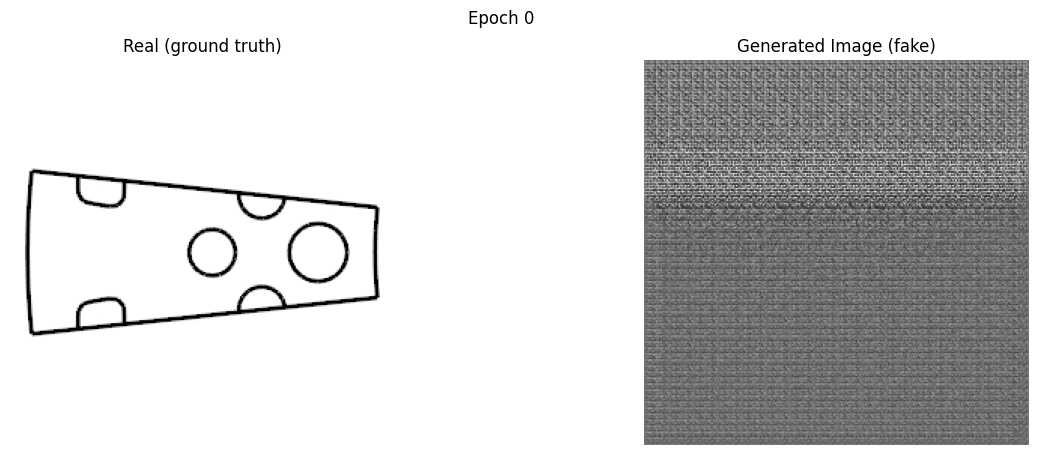

step: 0
Step  tf.Tensor(1, shape=(), dtype=int64)
Step  tf.Tensor(2, shape=(), dtype=int64)
Step  tf.Tensor(3, shape=(), dtype=int64)
Step  tf.Tensor(4, shape=(), dtype=int64)
Step  tf.Tensor(5, shape=(), dtype=int64)


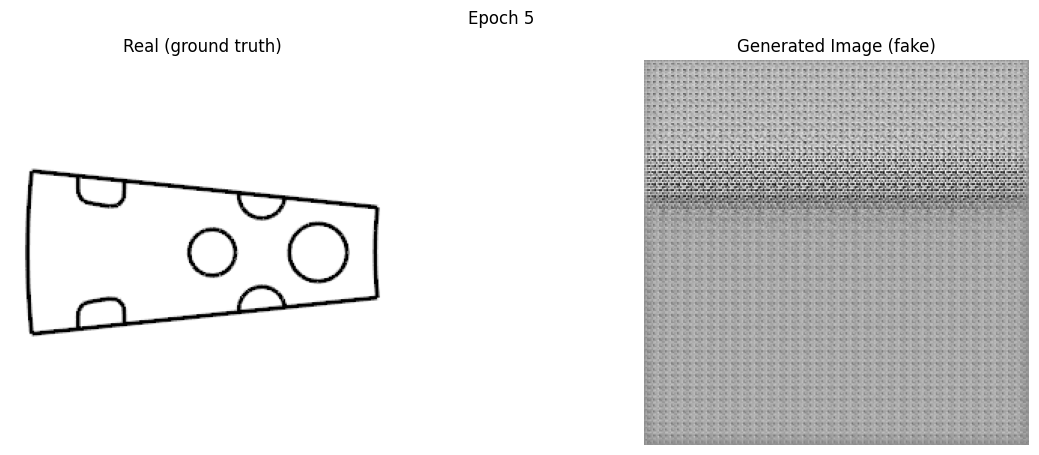

step: 5
Step  tf.Tensor(6, shape=(), dtype=int64)
Step  tf.Tensor(7, shape=(), dtype=int64)
Step  tf.Tensor(8, shape=(), dtype=int64)
Step  tf.Tensor(9, shape=(), dtype=int64)
Step  tf.Tensor(10, shape=(), dtype=int64)


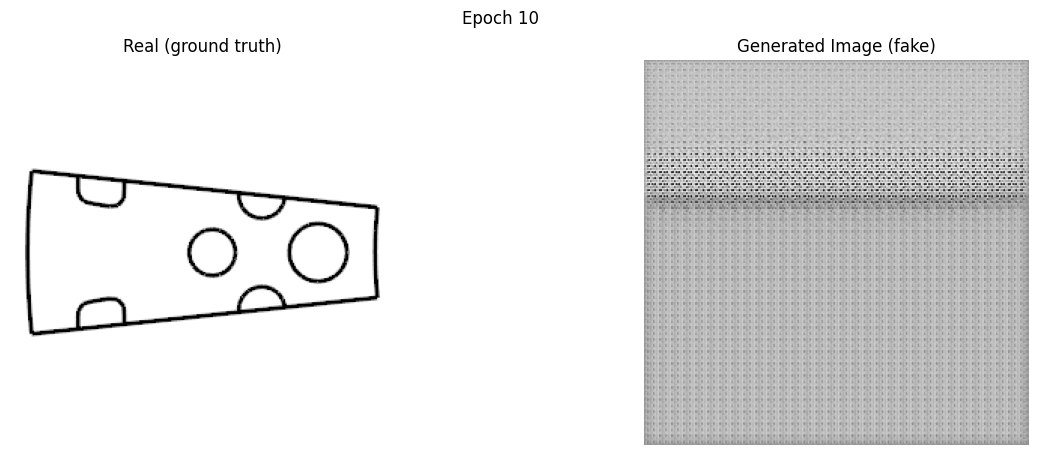

step: 10
Step  tf.Tensor(11, shape=(), dtype=int64)
Step  tf.Tensor(12, shape=(), dtype=int64)
Step  tf.Tensor(13, shape=(), dtype=int64)
Step  tf.Tensor(14, shape=(), dtype=int64)
Step  tf.Tensor(15, shape=(), dtype=int64)


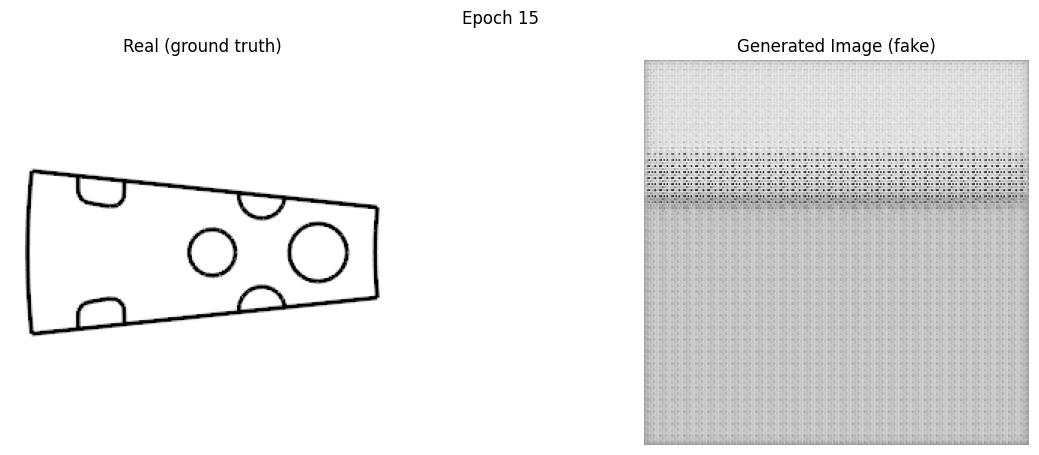

step: 15
Step  tf.Tensor(16, shape=(), dtype=int64)
Step  tf.Tensor(17, shape=(), dtype=int64)
Step  tf.Tensor(18, shape=(), dtype=int64)
Step  tf.Tensor(19, shape=(), dtype=int64)
Step  tf.Tensor(20, shape=(), dtype=int64)


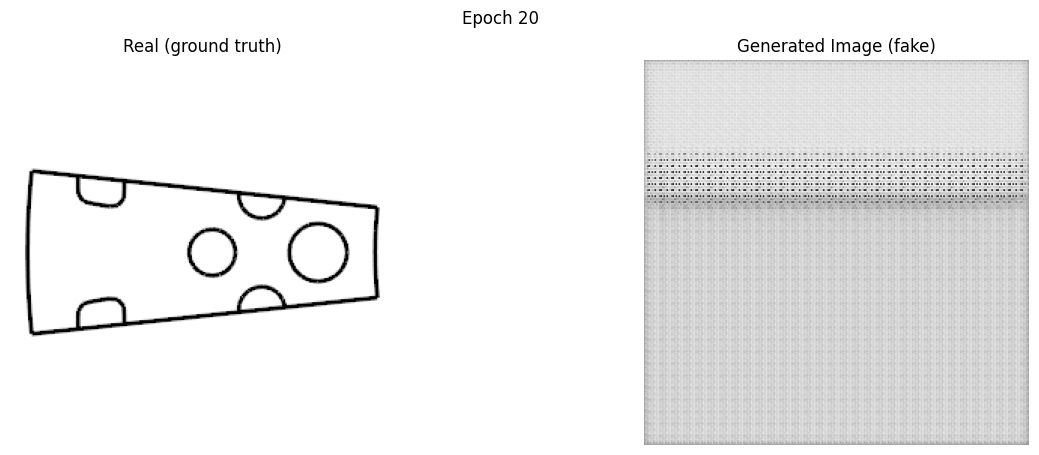

step: 20
Step  tf.Tensor(21, shape=(), dtype=int64)
Step  tf.Tensor(22, shape=(), dtype=int64)
Step  tf.Tensor(23, shape=(), dtype=int64)
Step  tf.Tensor(24, shape=(), dtype=int64)
Step  tf.Tensor(25, shape=(), dtype=int64)


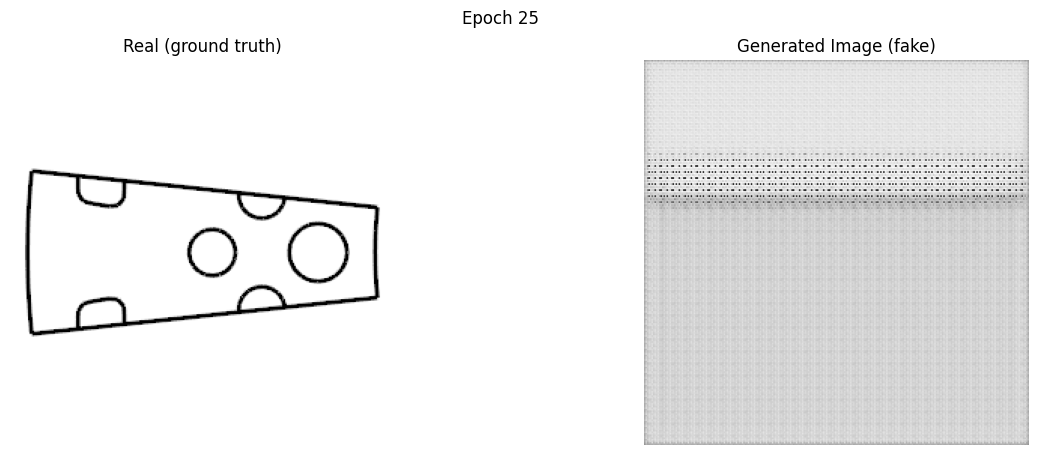

step: 25
Step  tf.Tensor(26, shape=(), dtype=int64)
Step  tf.Tensor(27, shape=(), dtype=int64)
Step  tf.Tensor(28, shape=(), dtype=int64)
Step  tf.Tensor(29, shape=(), dtype=int64)
Step  tf.Tensor(30, shape=(), dtype=int64)


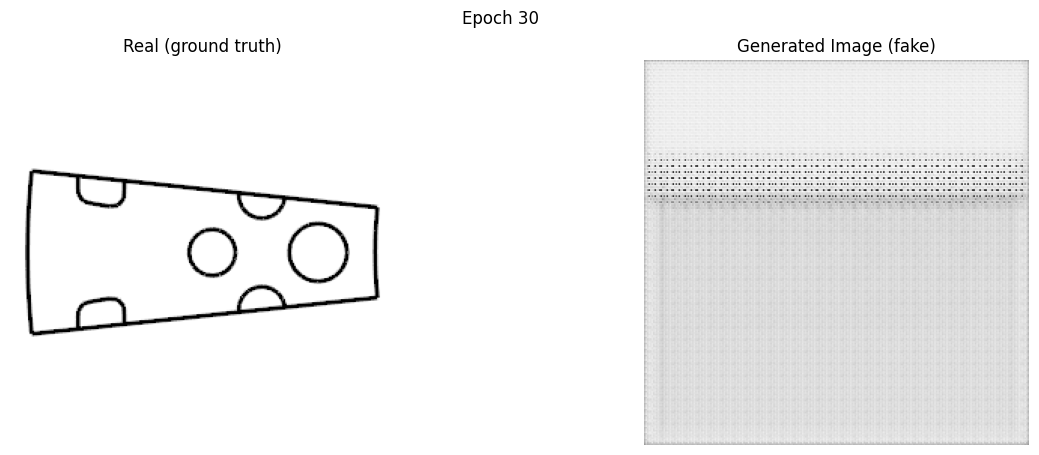

step: 30
Step  tf.Tensor(31, shape=(), dtype=int64)
Step  tf.Tensor(32, shape=(), dtype=int64)
Step  tf.Tensor(33, shape=(), dtype=int64)
Step  tf.Tensor(34, shape=(), dtype=int64)
Step  tf.Tensor(35, shape=(), dtype=int64)


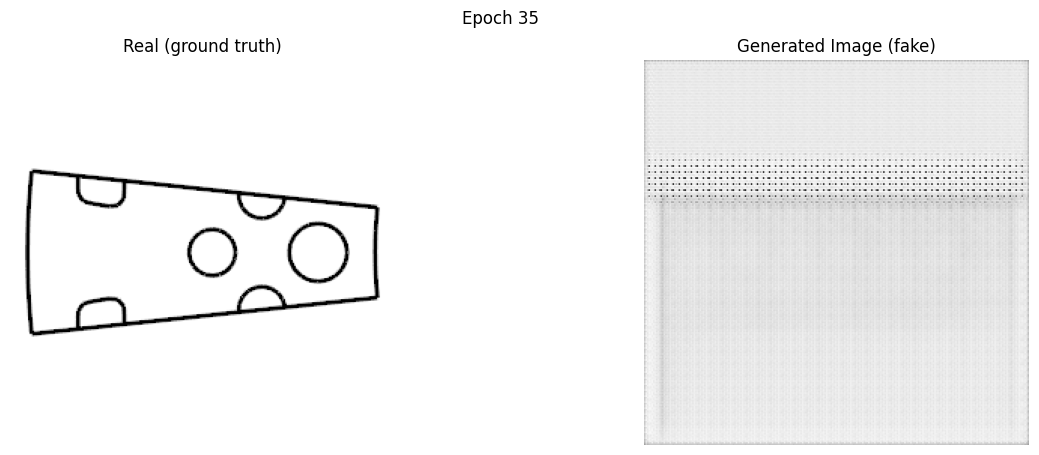

step: 35
Step  tf.Tensor(36, shape=(), dtype=int64)
Step  tf.Tensor(37, shape=(), dtype=int64)
Step  tf.Tensor(38, shape=(), dtype=int64)
Step  tf.Tensor(39, shape=(), dtype=int64)
Step  tf.Tensor(40, shape=(), dtype=int64)


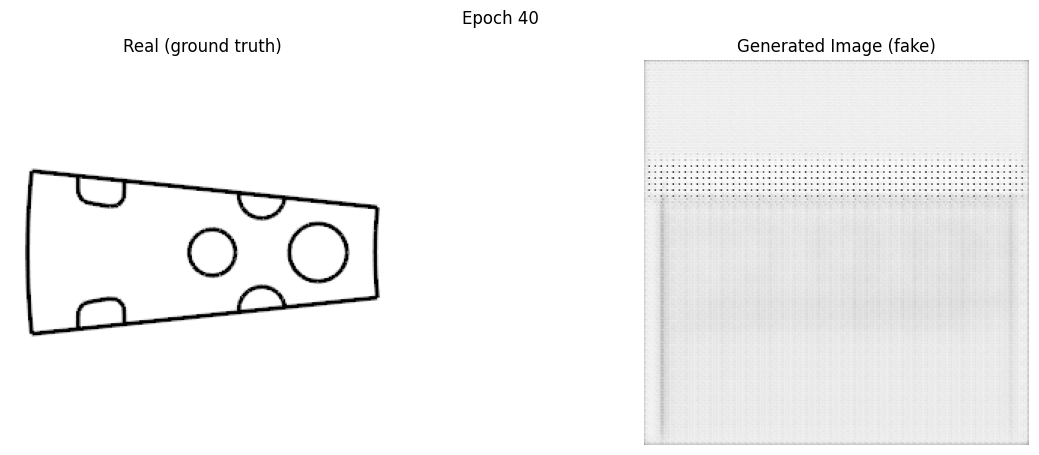

step: 40
Step  tf.Tensor(41, shape=(), dtype=int64)
Step  tf.Tensor(42, shape=(), dtype=int64)
Step  tf.Tensor(43, shape=(), dtype=int64)
Step  tf.Tensor(44, shape=(), dtype=int64)
Step  tf.Tensor(45, shape=(), dtype=int64)


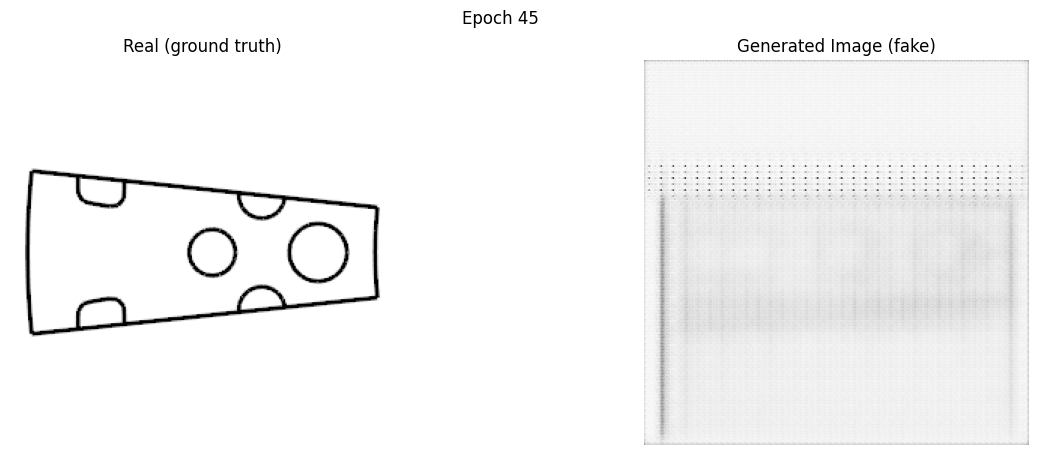

step: 45
Step  tf.Tensor(46, shape=(), dtype=int64)
Step  tf.Tensor(47, shape=(), dtype=int64)
Step  tf.Tensor(48, shape=(), dtype=int64)
Step  tf.Tensor(49, shape=(), dtype=int64)
Step  tf.Tensor(50, shape=(), dtype=int64)


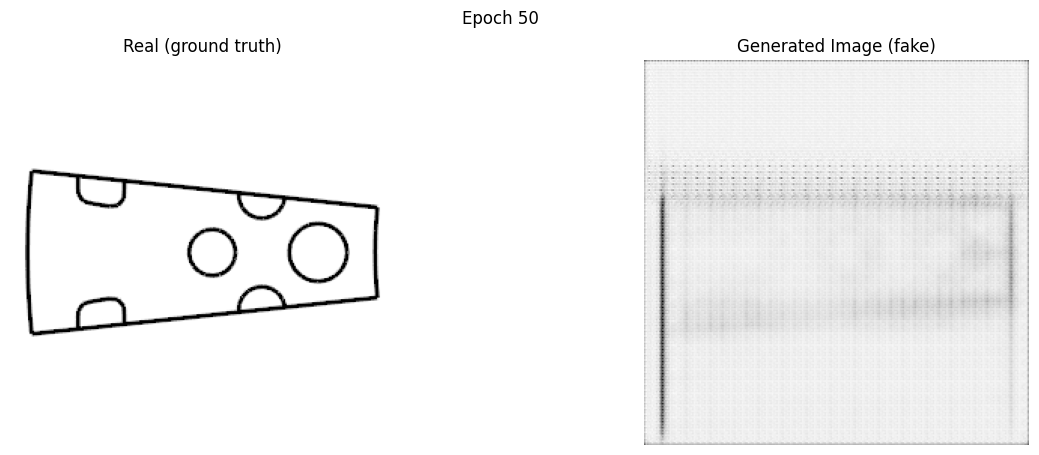

step: 50
Step  tf.Tensor(51, shape=(), dtype=int64)
Step  tf.Tensor(52, shape=(), dtype=int64)
Step  tf.Tensor(53, shape=(), dtype=int64)
Step  tf.Tensor(54, shape=(), dtype=int64)
Step  tf.Tensor(55, shape=(), dtype=int64)


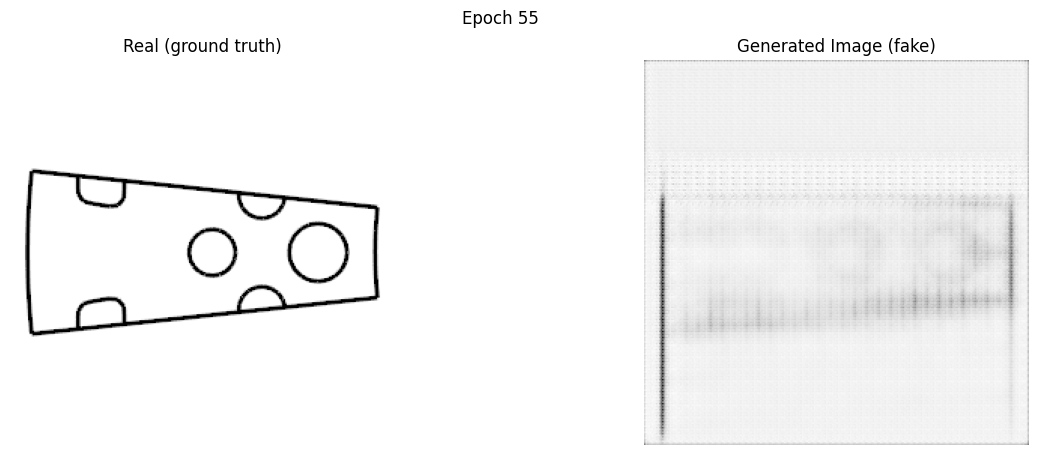

step: 55
Step  tf.Tensor(56, shape=(), dtype=int64)
Step  tf.Tensor(57, shape=(), dtype=int64)
Step  tf.Tensor(58, shape=(), dtype=int64)
Step  tf.Tensor(59, shape=(), dtype=int64)
Step  tf.Tensor(60, shape=(), dtype=int64)


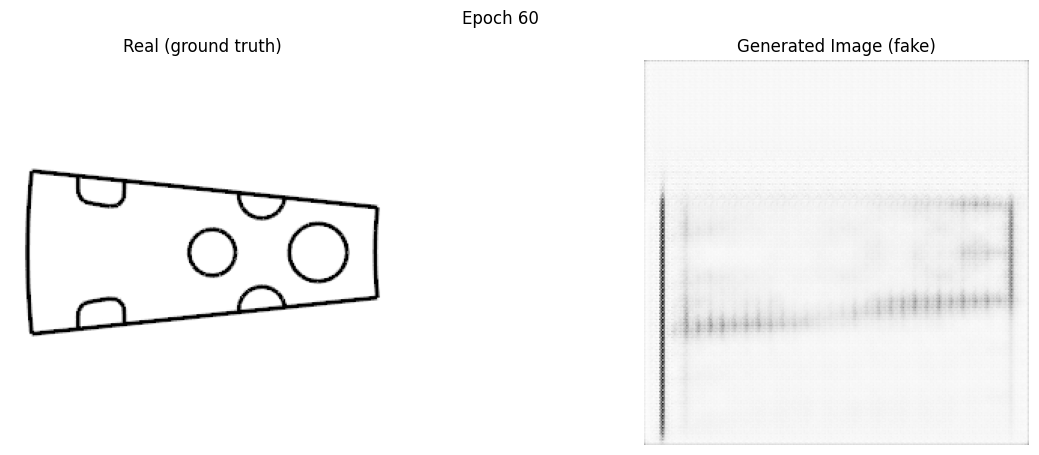

step: 60
Step  tf.Tensor(61, shape=(), dtype=int64)
Step  tf.Tensor(62, shape=(), dtype=int64)
Step  tf.Tensor(63, shape=(), dtype=int64)
Step  tf.Tensor(64, shape=(), dtype=int64)
Step  tf.Tensor(65, shape=(), dtype=int64)


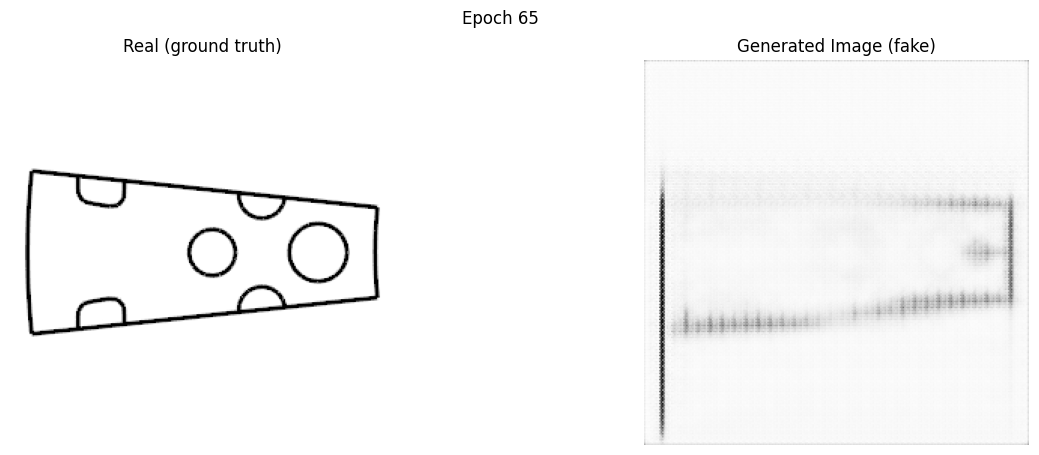

step: 65
Step  tf.Tensor(66, shape=(), dtype=int64)
Step  tf.Tensor(67, shape=(), dtype=int64)
Step  tf.Tensor(68, shape=(), dtype=int64)
Step  tf.Tensor(69, shape=(), dtype=int64)
Step  tf.Tensor(70, shape=(), dtype=int64)


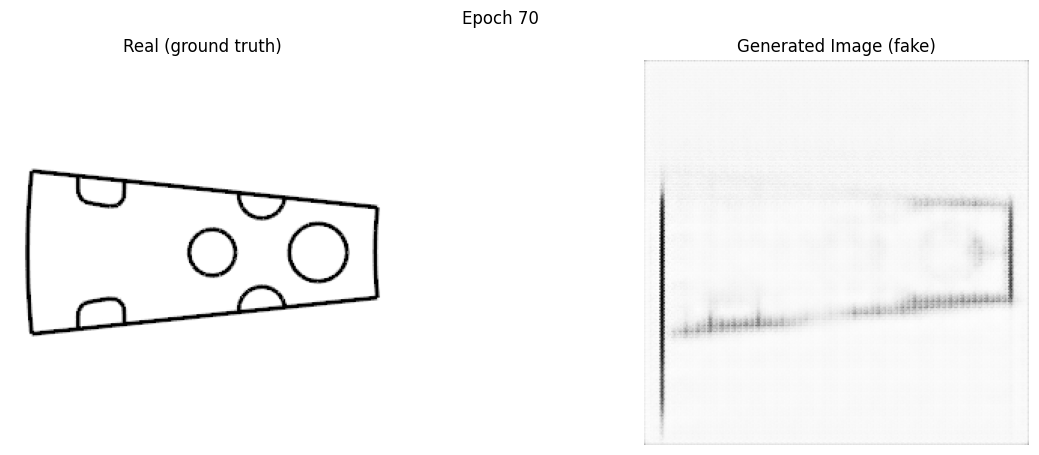

step: 70
Step  tf.Tensor(71, shape=(), dtype=int64)
Step  tf.Tensor(72, shape=(), dtype=int64)
Step  tf.Tensor(73, shape=(), dtype=int64)
Step  tf.Tensor(74, shape=(), dtype=int64)
Step  tf.Tensor(75, shape=(), dtype=int64)


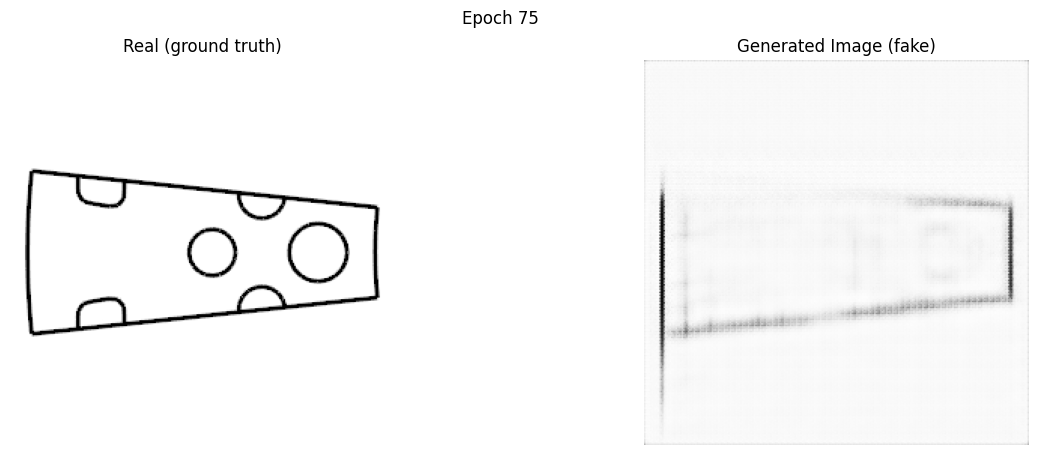

step: 75
Step  tf.Tensor(76, shape=(), dtype=int64)
Step  tf.Tensor(77, shape=(), dtype=int64)
Step  tf.Tensor(78, shape=(), dtype=int64)
Step  tf.Tensor(79, shape=(), dtype=int64)
Step  tf.Tensor(80, shape=(), dtype=int64)


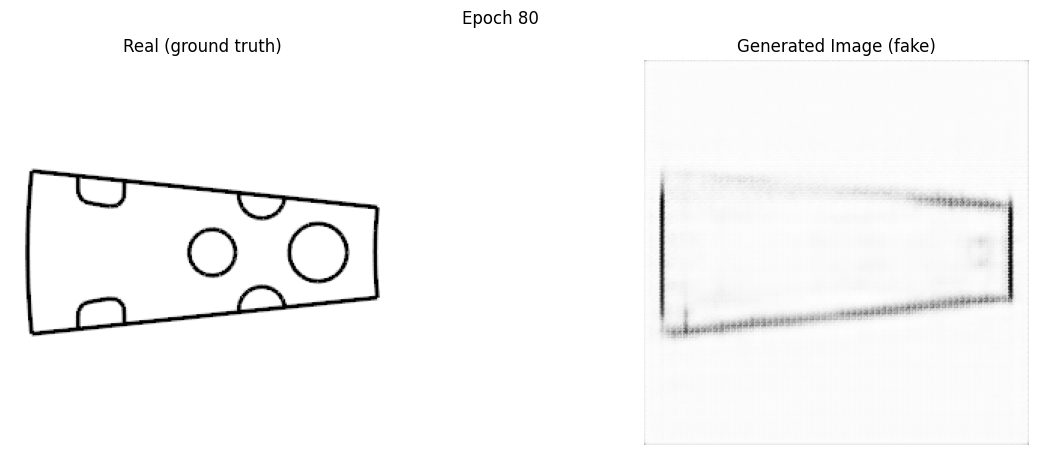

step: 80
Step  tf.Tensor(81, shape=(), dtype=int64)
Step  tf.Tensor(82, shape=(), dtype=int64)
Step  tf.Tensor(83, shape=(), dtype=int64)
Step  tf.Tensor(84, shape=(), dtype=int64)
Step  tf.Tensor(85, shape=(), dtype=int64)


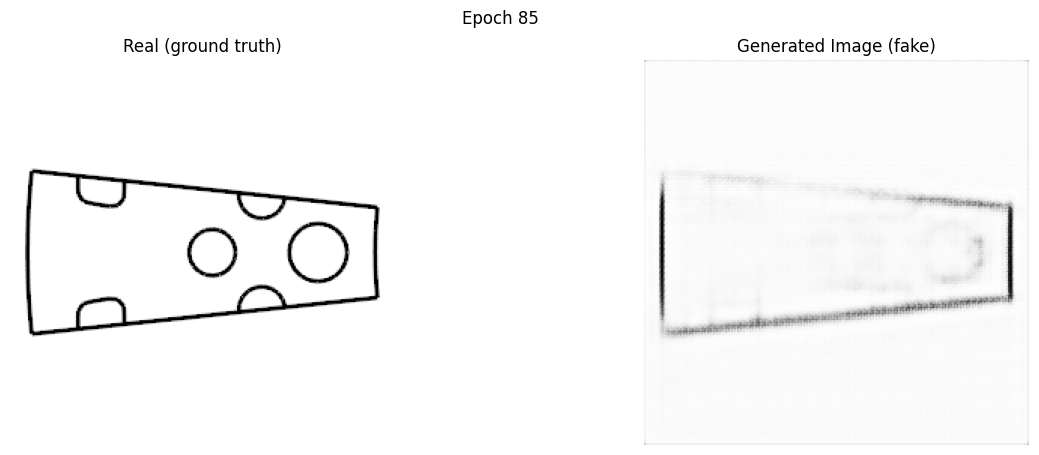

step: 85
Step  tf.Tensor(86, shape=(), dtype=int64)
Step  tf.Tensor(87, shape=(), dtype=int64)
Step  tf.Tensor(88, shape=(), dtype=int64)
Step  tf.Tensor(89, shape=(), dtype=int64)
Step  tf.Tensor(90, shape=(), dtype=int64)


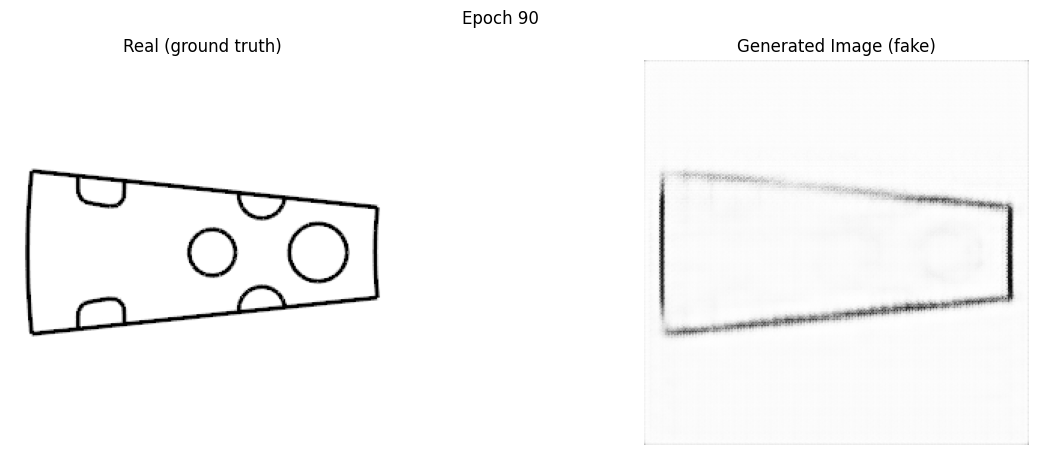

step: 90
Step  tf.Tensor(91, shape=(), dtype=int64)
Step  tf.Tensor(92, shape=(), dtype=int64)
Step  tf.Tensor(93, shape=(), dtype=int64)
Step  tf.Tensor(94, shape=(), dtype=int64)
Step  tf.Tensor(95, shape=(), dtype=int64)


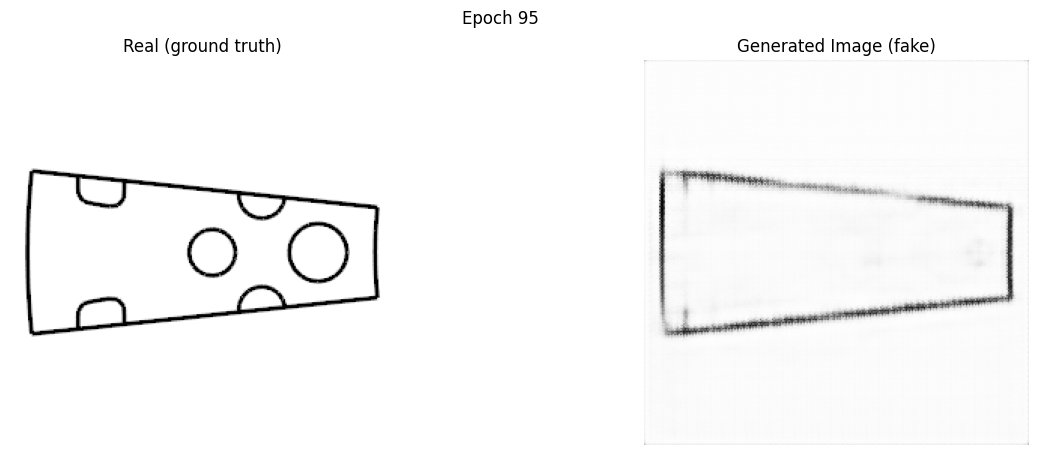

step: 95
Step  tf.Tensor(96, shape=(), dtype=int64)
Step  tf.Tensor(97, shape=(), dtype=int64)
Step  tf.Tensor(98, shape=(), dtype=int64)
Step  tf.Tensor(99, shape=(), dtype=int64)
Step  tf.Tensor(100, shape=(), dtype=int64)


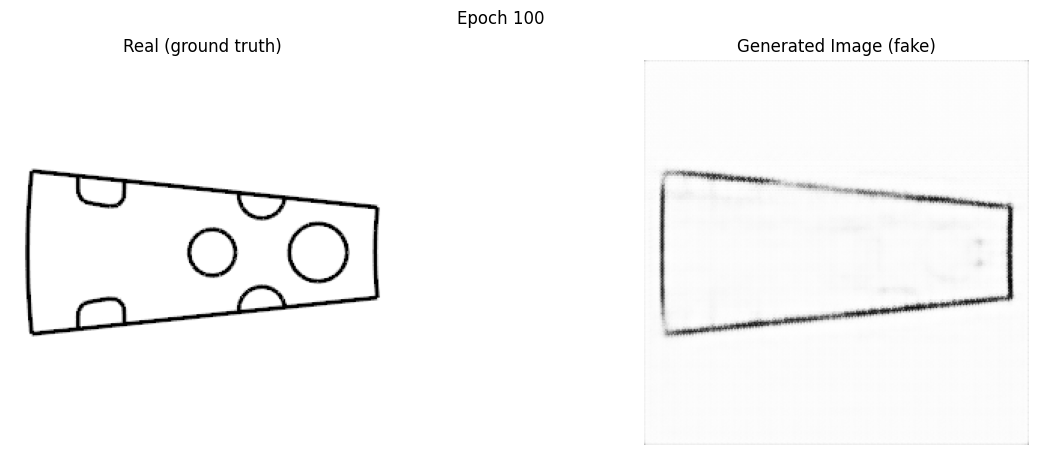

step: 100
Step  tf.Tensor(101, shape=(), dtype=int64)
Step  tf.Tensor(102, shape=(), dtype=int64)
Step  tf.Tensor(103, shape=(), dtype=int64)
Step  tf.Tensor(104, shape=(), dtype=int64)
Step  tf.Tensor(105, shape=(), dtype=int64)


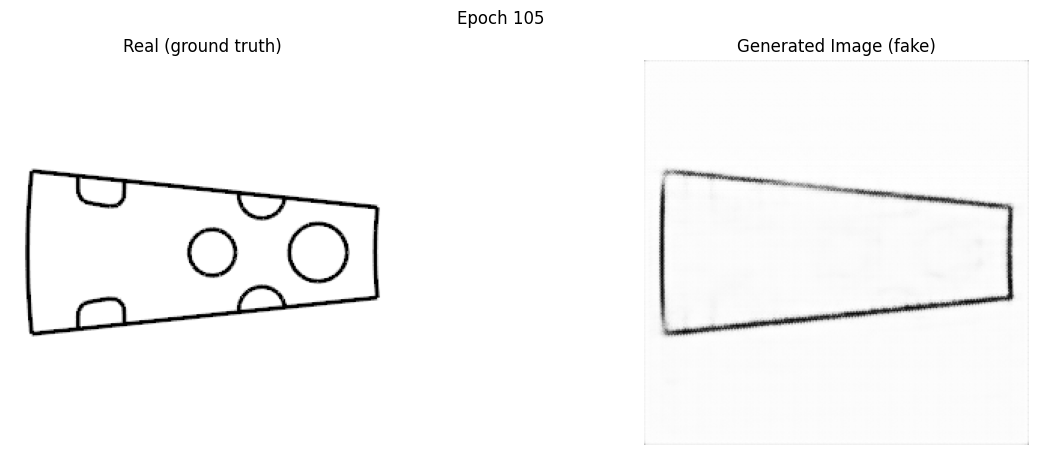

step: 105
Step  tf.Tensor(106, shape=(), dtype=int64)
Step  tf.Tensor(107, shape=(), dtype=int64)
Step  tf.Tensor(108, shape=(), dtype=int64)
Step  tf.Tensor(109, shape=(), dtype=int64)
Step  tf.Tensor(110, shape=(), dtype=int64)


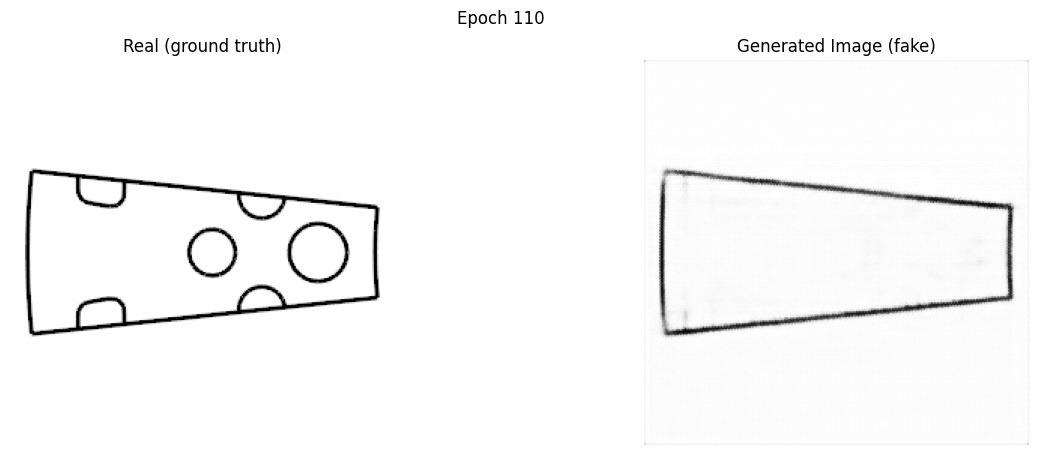

step: 110
Step  tf.Tensor(111, shape=(), dtype=int64)
Step  tf.Tensor(112, shape=(), dtype=int64)
Step  tf.Tensor(113, shape=(), dtype=int64)
Step  tf.Tensor(114, shape=(), dtype=int64)
Step  tf.Tensor(115, shape=(), dtype=int64)


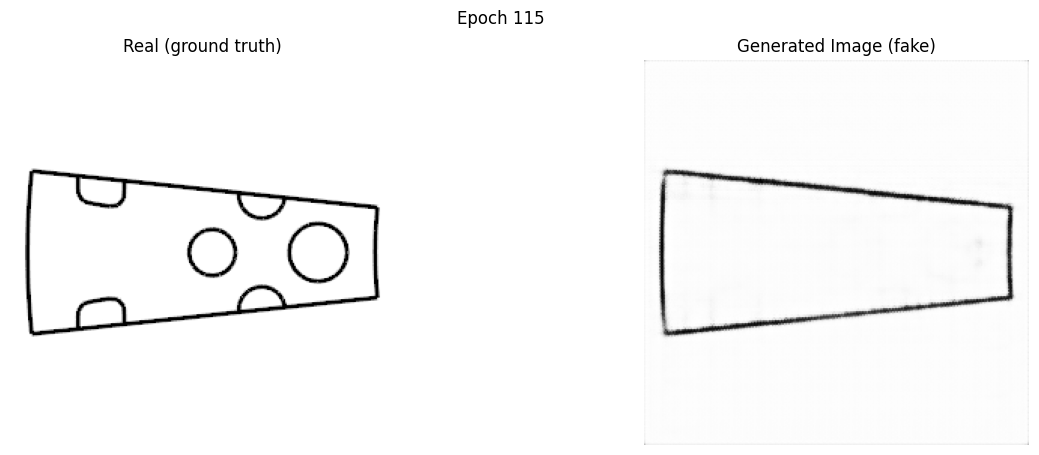

step: 115
Step  tf.Tensor(116, shape=(), dtype=int64)
Step  tf.Tensor(117, shape=(), dtype=int64)
Step  tf.Tensor(118, shape=(), dtype=int64)
Step  tf.Tensor(119, shape=(), dtype=int64)
Step  tf.Tensor(120, shape=(), dtype=int64)


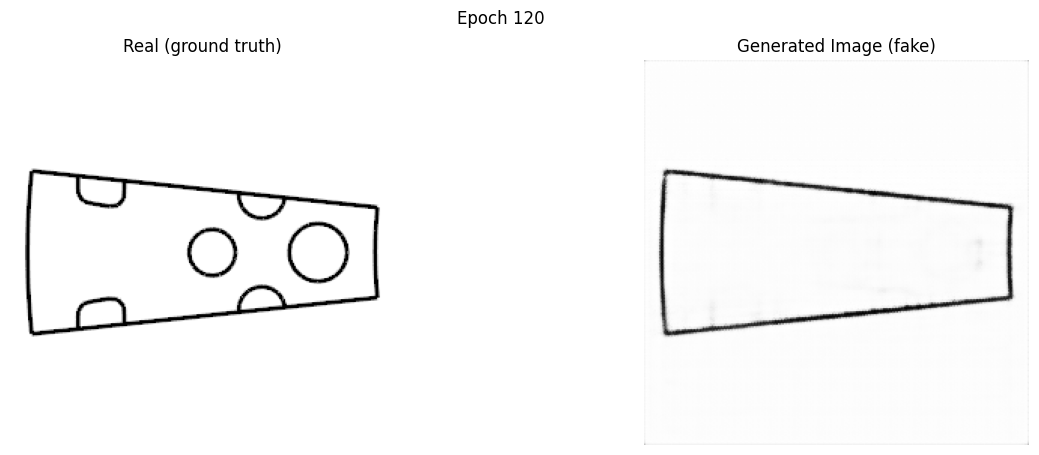

step: 120
Step  tf.Tensor(121, shape=(), dtype=int64)
Step  tf.Tensor(122, shape=(), dtype=int64)
Step  tf.Tensor(123, shape=(), dtype=int64)
Step  tf.Tensor(124, shape=(), dtype=int64)
Step  tf.Tensor(125, shape=(), dtype=int64)


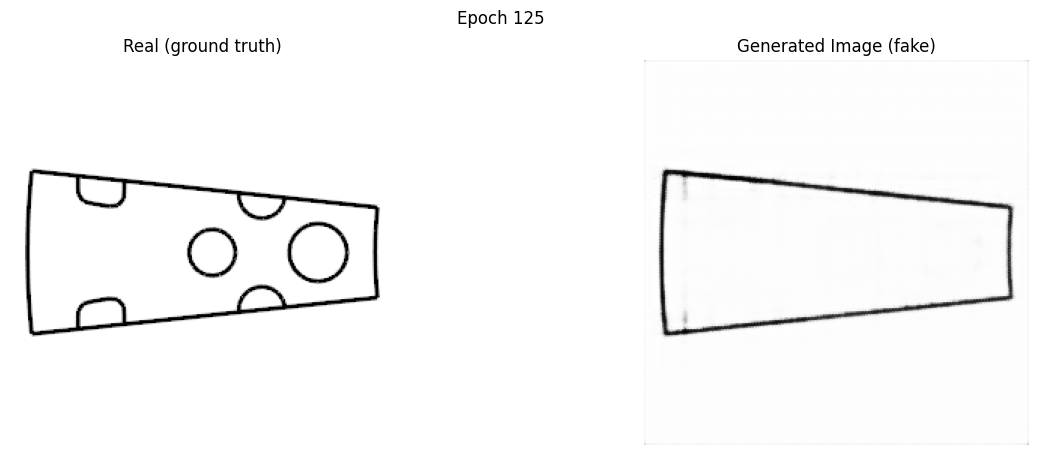

step: 125
Step  tf.Tensor(126, shape=(), dtype=int64)
Step  tf.Tensor(127, shape=(), dtype=int64)
Step  tf.Tensor(128, shape=(), dtype=int64)
Step  tf.Tensor(129, shape=(), dtype=int64)
Step  tf.Tensor(130, shape=(), dtype=int64)


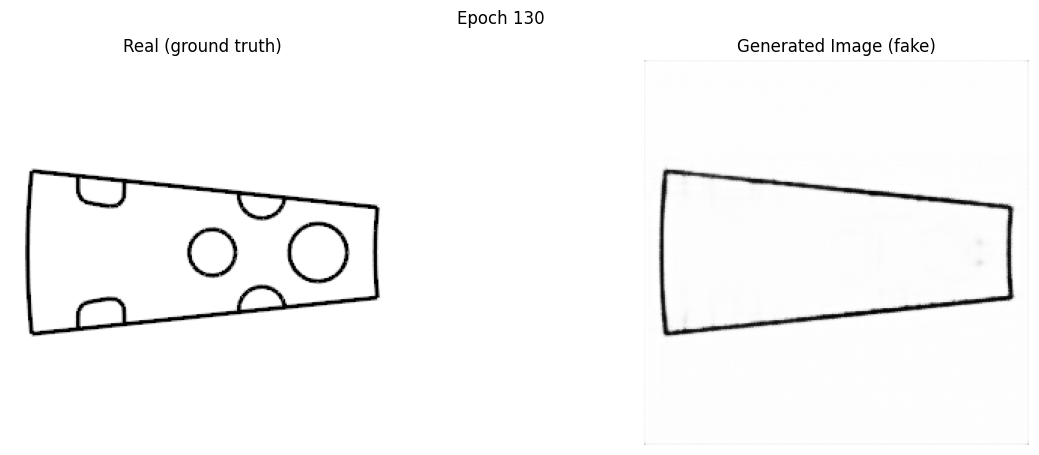

step: 130
Step  tf.Tensor(131, shape=(), dtype=int64)
Step  tf.Tensor(132, shape=(), dtype=int64)
Step  tf.Tensor(133, shape=(), dtype=int64)
Step  tf.Tensor(134, shape=(), dtype=int64)
Step  tf.Tensor(135, shape=(), dtype=int64)


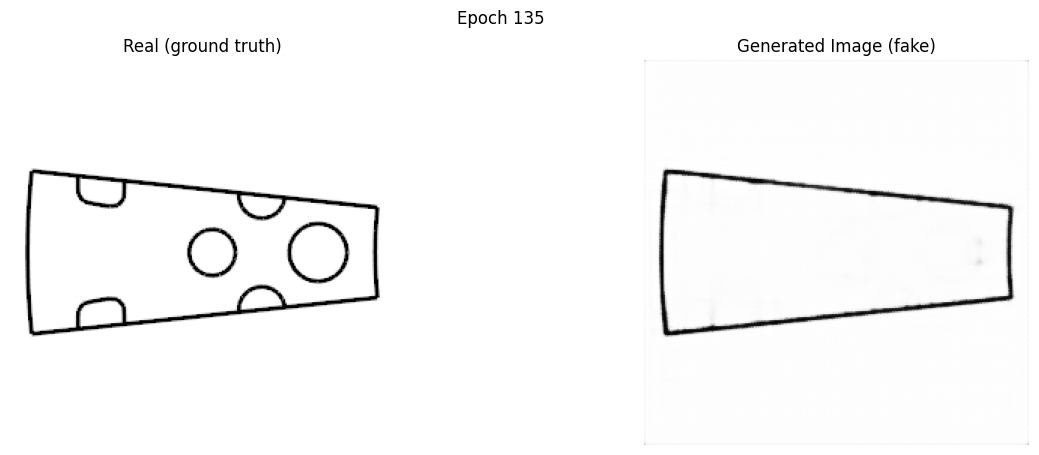

step: 135
Step  tf.Tensor(136, shape=(), dtype=int64)
Step  tf.Tensor(137, shape=(), dtype=int64)
Step  tf.Tensor(138, shape=(), dtype=int64)
Step  tf.Tensor(139, shape=(), dtype=int64)
Step  tf.Tensor(140, shape=(), dtype=int64)


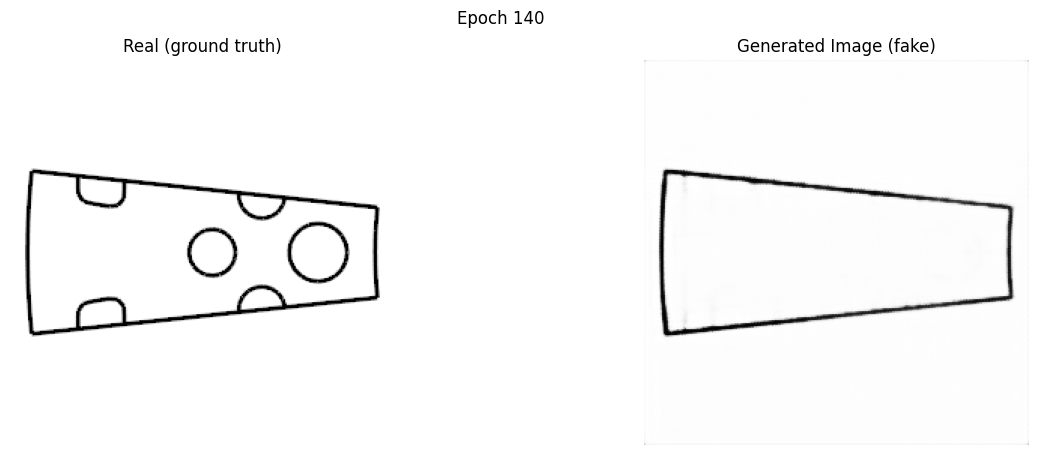

step: 140
Step  tf.Tensor(141, shape=(), dtype=int64)
Step  tf.Tensor(142, shape=(), dtype=int64)
Step  tf.Tensor(143, shape=(), dtype=int64)
Step  tf.Tensor(144, shape=(), dtype=int64)
Step  tf.Tensor(145, shape=(), dtype=int64)


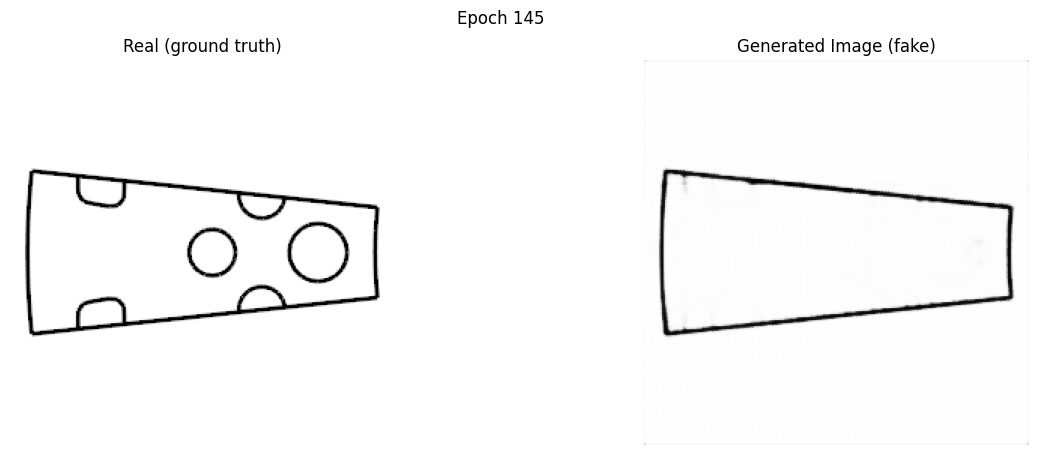

step: 145
Step  tf.Tensor(146, shape=(), dtype=int64)
Step  tf.Tensor(147, shape=(), dtype=int64)
Step  tf.Tensor(148, shape=(), dtype=int64)
Step  tf.Tensor(149, shape=(), dtype=int64)
Step  tf.Tensor(150, shape=(), dtype=int64)


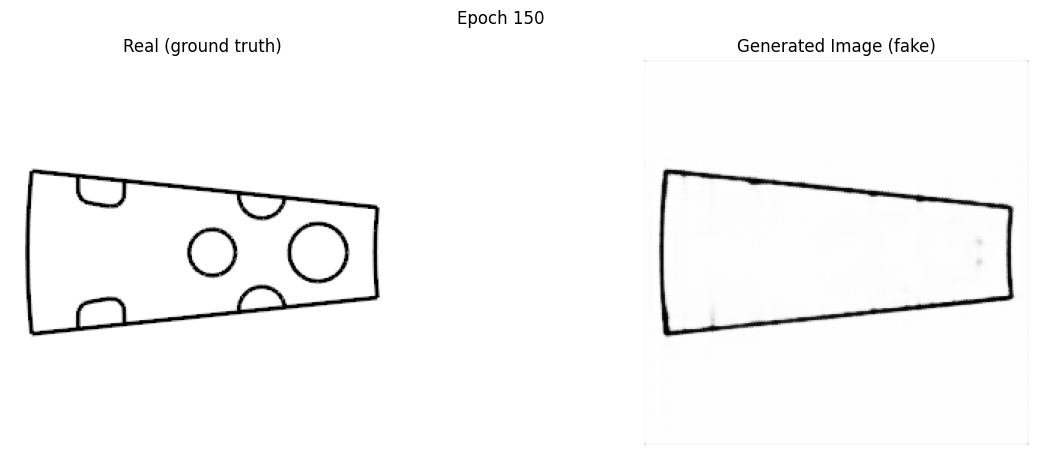

step: 150
Step  tf.Tensor(151, shape=(), dtype=int64)
Step  tf.Tensor(152, shape=(), dtype=int64)
Step  tf.Tensor(153, shape=(), dtype=int64)
Step  tf.Tensor(154, shape=(), dtype=int64)
Step  tf.Tensor(155, shape=(), dtype=int64)


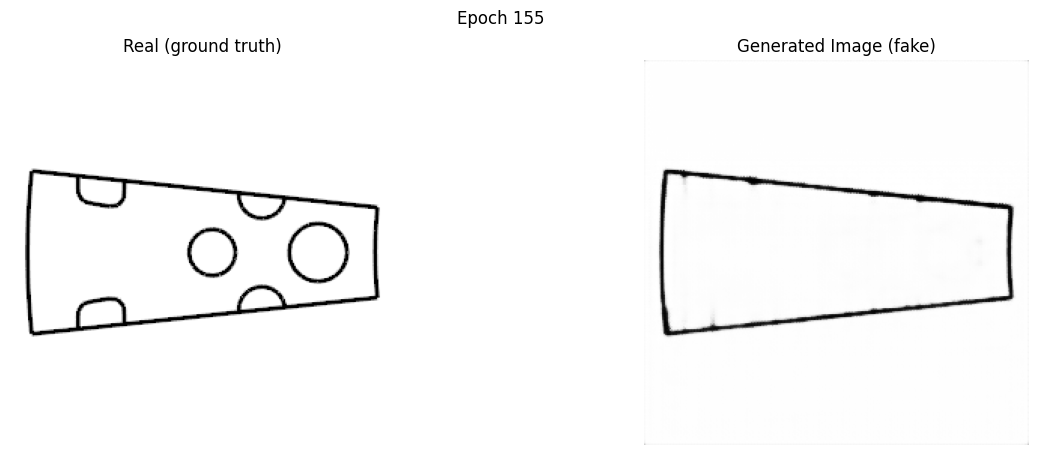

step: 155
Step  tf.Tensor(156, shape=(), dtype=int64)
Step  tf.Tensor(157, shape=(), dtype=int64)
Step  tf.Tensor(158, shape=(), dtype=int64)
Step  tf.Tensor(159, shape=(), dtype=int64)
Step  tf.Tensor(160, shape=(), dtype=int64)


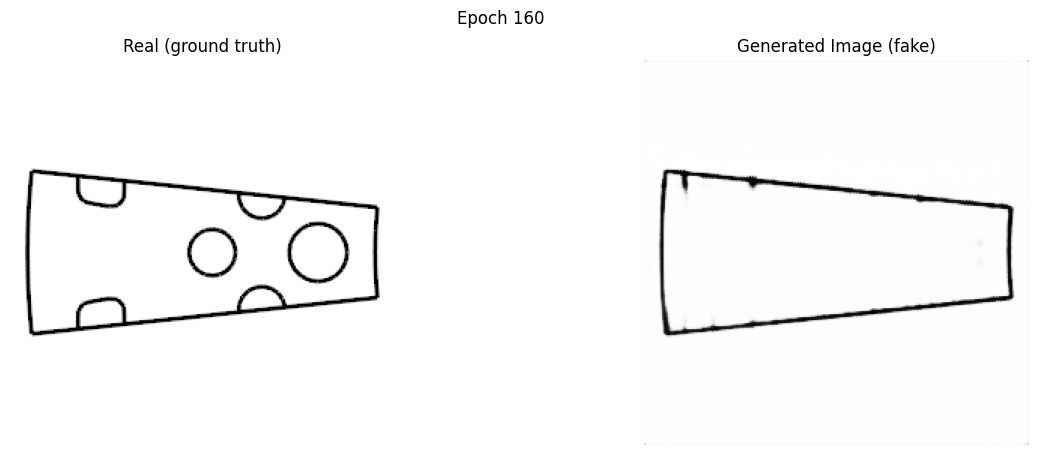

step: 160
Step  tf.Tensor(161, shape=(), dtype=int64)
Step  tf.Tensor(162, shape=(), dtype=int64)
Step  tf.Tensor(163, shape=(), dtype=int64)
Step  tf.Tensor(164, shape=(), dtype=int64)
Step  tf.Tensor(165, shape=(), dtype=int64)


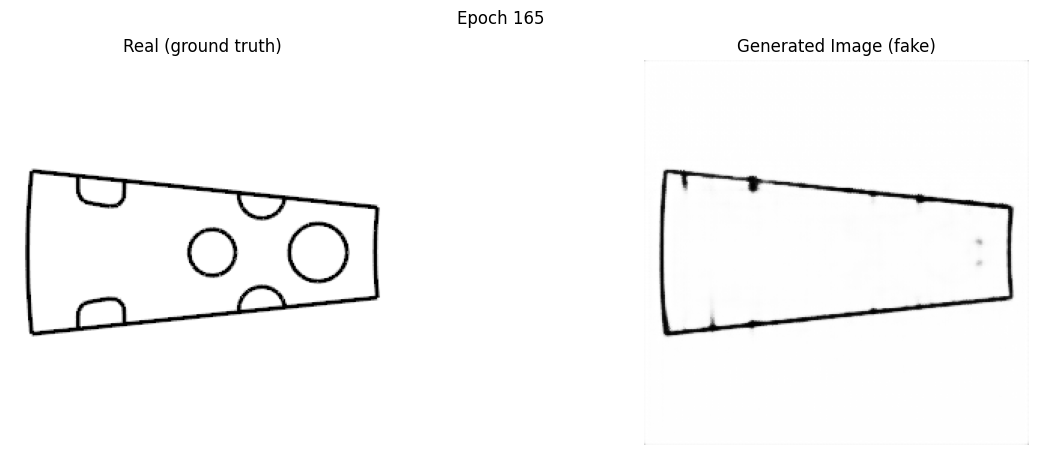

step: 165
Step  tf.Tensor(166, shape=(), dtype=int64)
Step  tf.Tensor(167, shape=(), dtype=int64)
Step  tf.Tensor(168, shape=(), dtype=int64)
Step  tf.Tensor(169, shape=(), dtype=int64)
Step  tf.Tensor(170, shape=(), dtype=int64)


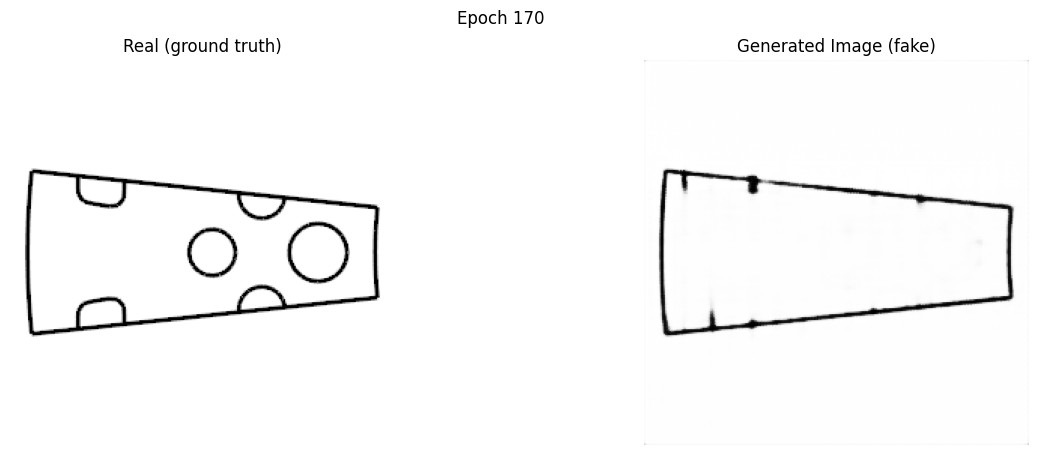

step: 170
Step  tf.Tensor(171, shape=(), dtype=int64)
Step  tf.Tensor(172, shape=(), dtype=int64)
Step  tf.Tensor(173, shape=(), dtype=int64)
Step  tf.Tensor(174, shape=(), dtype=int64)
Step  tf.Tensor(175, shape=(), dtype=int64)


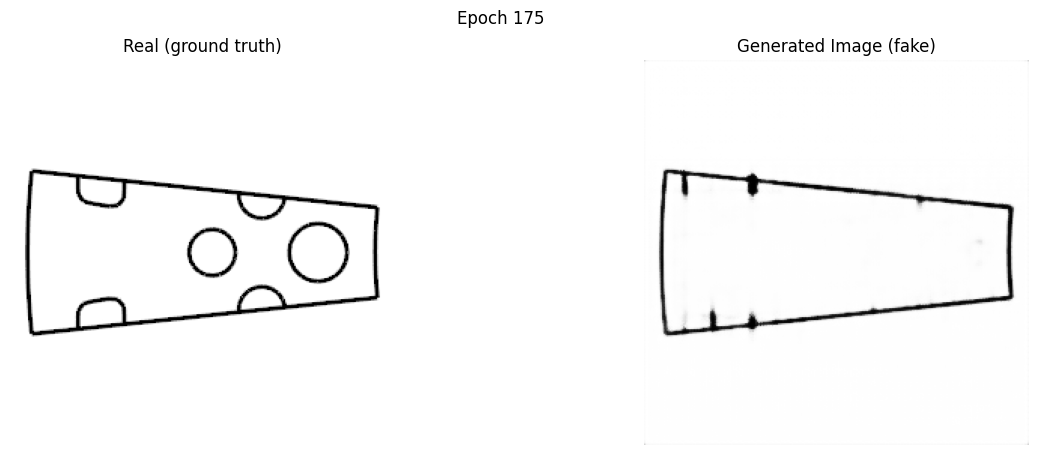

step: 175
Step  tf.Tensor(176, shape=(), dtype=int64)
Step  tf.Tensor(177, shape=(), dtype=int64)
Step  tf.Tensor(178, shape=(), dtype=int64)
Step  tf.Tensor(179, shape=(), dtype=int64)
Step  tf.Tensor(180, shape=(), dtype=int64)


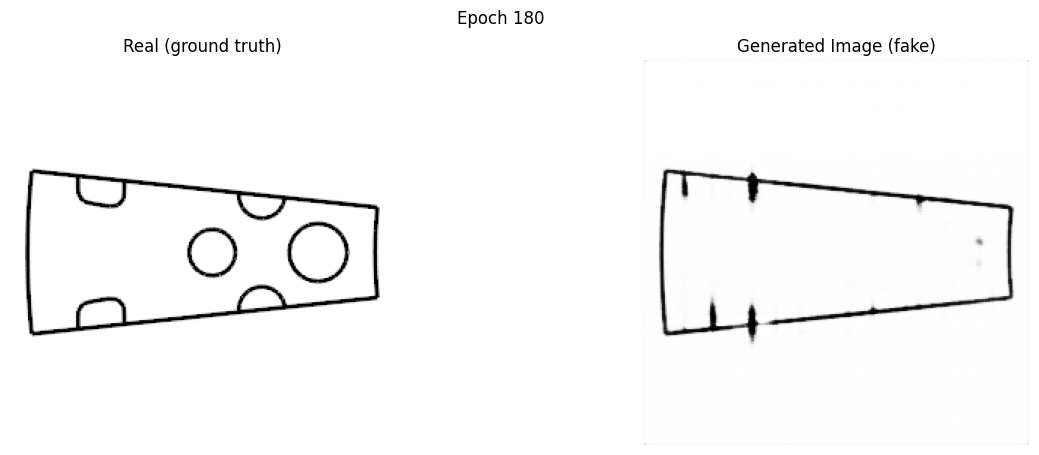

step: 180
Step  tf.Tensor(181, shape=(), dtype=int64)
Step  tf.Tensor(182, shape=(), dtype=int64)
Step  tf.Tensor(183, shape=(), dtype=int64)
Step  tf.Tensor(184, shape=(), dtype=int64)
Step  tf.Tensor(185, shape=(), dtype=int64)


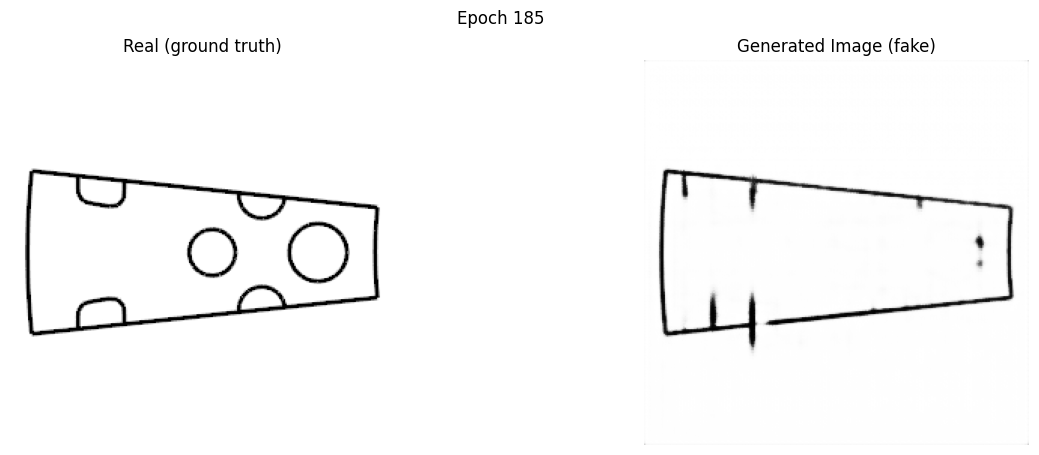

step: 185
Step  tf.Tensor(186, shape=(), dtype=int64)
Step  tf.Tensor(187, shape=(), dtype=int64)
Step  tf.Tensor(188, shape=(), dtype=int64)
Step  tf.Tensor(189, shape=(), dtype=int64)
Step  tf.Tensor(190, shape=(), dtype=int64)


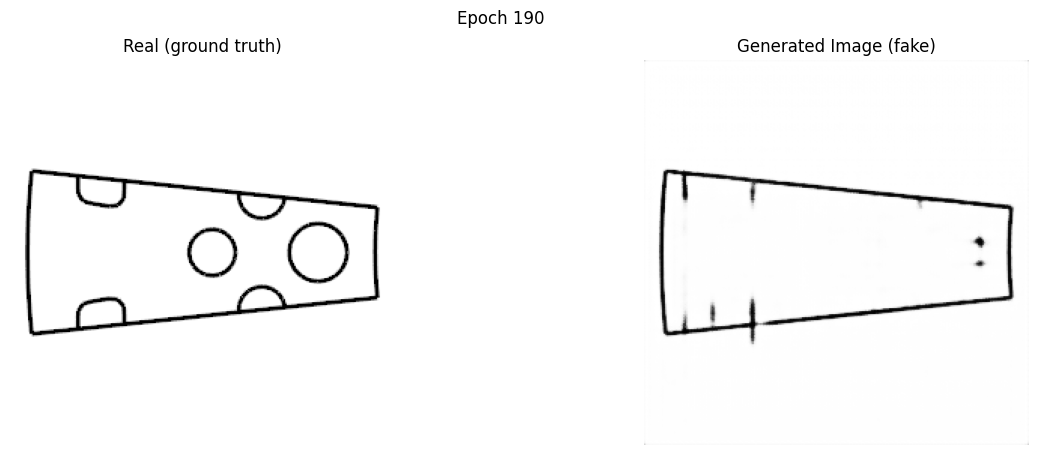

step: 190
Step  tf.Tensor(191, shape=(), dtype=int64)
Step  tf.Tensor(192, shape=(), dtype=int64)
Step  tf.Tensor(193, shape=(), dtype=int64)
Step  tf.Tensor(194, shape=(), dtype=int64)
Step  tf.Tensor(195, shape=(), dtype=int64)


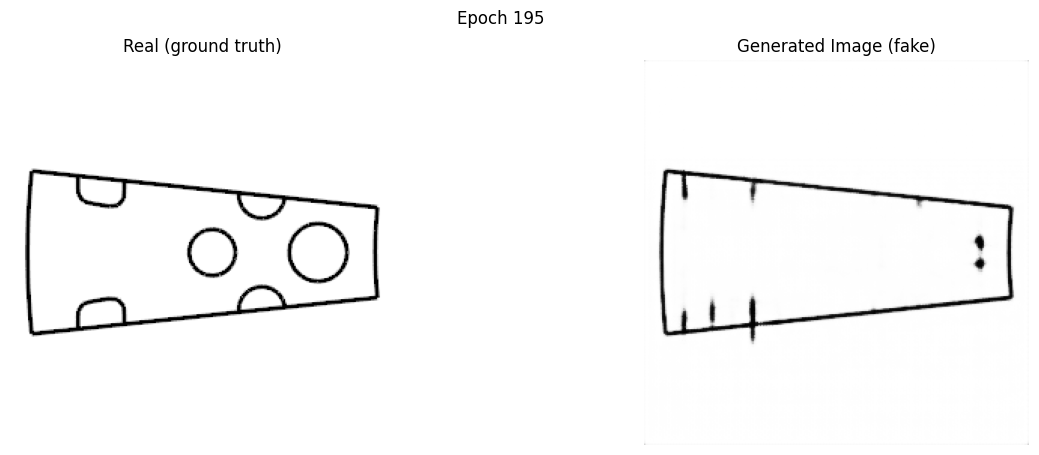

step: 195
Step  tf.Tensor(196, shape=(), dtype=int64)
Step  tf.Tensor(197, shape=(), dtype=int64)
Step  tf.Tensor(198, shape=(), dtype=int64)
Step  tf.Tensor(199, shape=(), dtype=int64)


In [37]:
train(train_data,200)

In [20]:
generator.save('p2p_combination4_generator.h5')

In [21]:
pred_in_com_1_tmp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\tmp_test_input\tmp_test_com_1_in.png"
pred_in_com_1_dsp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\dsp_test_input\dsp_test_com_1_in.png"

pred_in_com_1_tmp = imread(pred_in_com_1_tmp_path)
pred_in_com_1_dsp = imread(pred_in_com_1_dsp_path)

pred_in_com_1_tmp = pred_in_com_1_tmp.reshape((256, 256, 1))
pred_in_com_1_dsp = pred_in_com_1_dsp.reshape((256, 256, 1))

pred_in_com_1 = np.concatenate((pred_in_com_1_tmp, pred_in_com_1_dsp), axis=2)

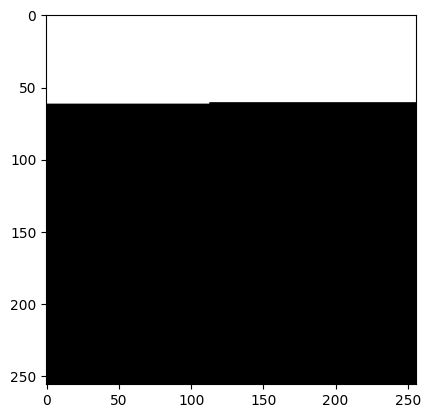

In [22]:
plt.imshow(pred_in_com_1_tmp, cmap = 'gray')

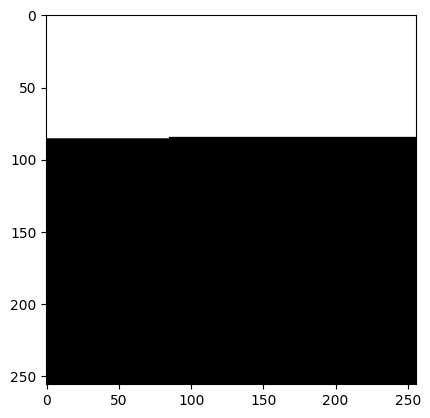

In [23]:
plt.imshow(pred_in_com_1_dsp, cmap = 'gray')

1/1 [==============================] - 0s 460ms/step


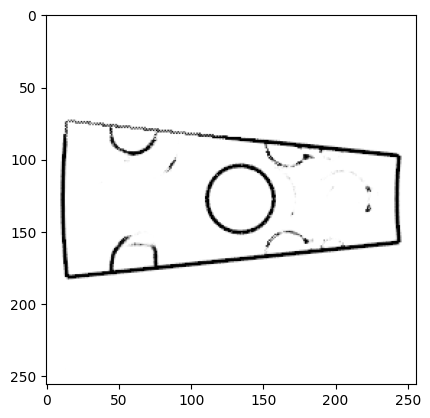

In [24]:
pred_in_com_1 = pred_in_com_1.reshape((1,256,256,2))

pred_out_com_1 = generator.predict(pred_in_com_1)

pred_out_com_1 = pred_out_com_1.reshape((256, 256))

plt.imshow(pred_out_com_1, cmap = 'gray')

In [25]:
pred_in_com_2_tmp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\tmp_test_input\tmp_test_com_2_in.png"
pred_in_com_2_dsp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\dsp_test_input\dsp_test_com_2_in.png"

pred_in_com_2_tmp = imread(pred_in_com_2_tmp_path)
pred_in_com_2_dsp = imread(pred_in_com_2_dsp_path)

pred_in_com_2_tmp = pred_in_com_2_tmp.reshape((256, 256, 1))
pred_in_com_2_dsp = pred_in_com_2_dsp.reshape((256, 256, 1))

pred_in_com_2 = np.concatenate((pred_in_com_2_tmp, pred_in_com_2_dsp), axis=2)

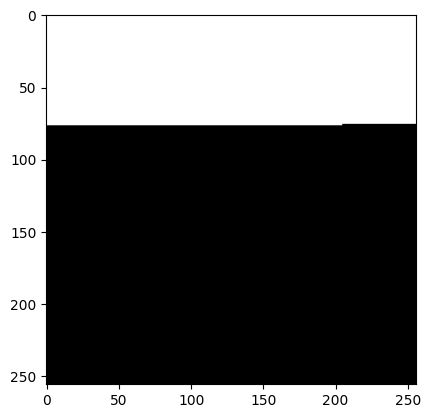

In [26]:
plt.imshow(pred_in_com_2_tmp, cmap = 'gray')

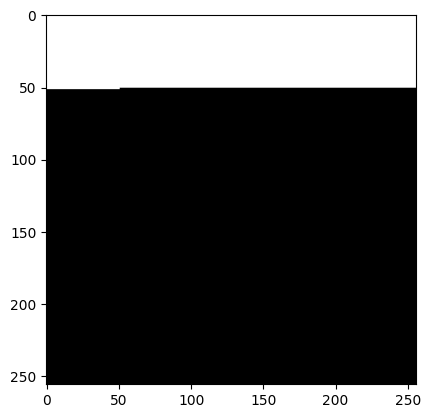

In [27]:
plt.imshow(pred_in_com_2_dsp, cmap = 'gray')

1/1 [==============================] - 0s 21ms/step


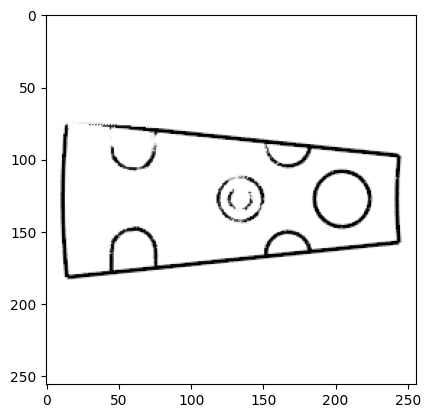

In [28]:
pred_in_com_2 = pred_in_com_2.reshape((1,256, 256, 2))

pred_out_com_2 = generator.predict(pred_in_com_2)

pred_out_com_2 = pred_out_com_2.reshape((256, 256))

plt.imshow(pred_out_com_2, cmap = 'gray')

In [29]:
pred_in_com_3_tmp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\tmp_test_input\tmp_test_com_3_in.png"
pred_in_com_3_dsp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\dsp_test_input\dsp_test_com_3_in.png"

pred_in_com_3_tmp = imread(pred_in_com_3_tmp_path)
pred_in_com_3_dsp = imread(pred_in_com_3_dsp_path)

pred_in_com_3_tmp = pred_in_com_3_tmp.reshape((256, 256, 1))
pred_in_com_3_dsp = pred_in_com_3_dsp.reshape((256, 256, 1))

pred_in_com_3 = np.concatenate((pred_in_com_3_tmp, pred_in_com_3_dsp), axis=2)

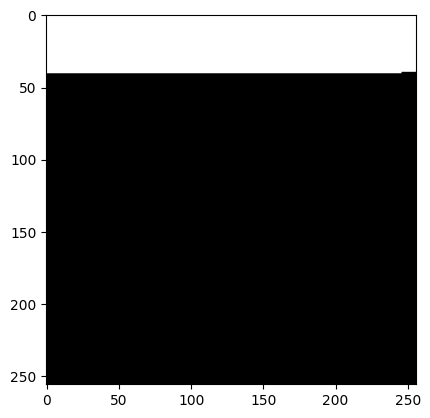

In [30]:
plt.imshow(pred_in_com_3_tmp, cmap = 'gray')

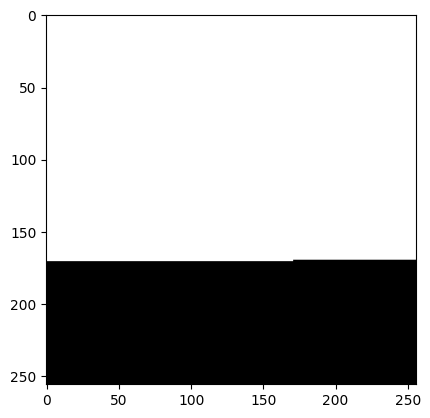

In [31]:
plt.imshow(pred_in_com_3_dsp, cmap = 'gray')

1/1 [==============================] - 0s 28ms/step


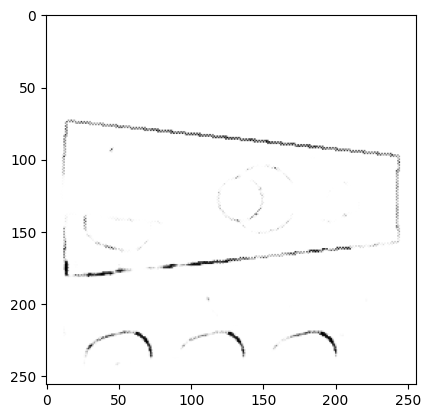

In [32]:
pred_in_com_3 = pred_in_com_3.reshape((1,256, 256, 2))

pred_out_com_3 = generator.predict(pred_in_com_3)

pred_out_com_3 = pred_out_com_3.reshape((256, 256))

plt.imshow(pred_out_com_3, cmap = 'gray')

In [33]:
pred_in_com_4_tmp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\tmp_test_input\tmp_test_com_4_in.png"
pred_in_com_4_dsp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\dsp_test_input\dsp_test_com_4_in.png"

pred_in_com_4_tmp = imread(pred_in_com_4_tmp_path)
pred_in_com_4_dsp = imread(pred_in_com_4_dsp_path)

pred_in_com_4_tmp = pred_in_com_4_tmp.reshape((256, 256, 1))
pred_in_com_4_dsp = pred_in_com_4_dsp.reshape((256, 256, 1))

pred_in_com_4 = np.concatenate((pred_in_com_4_tmp, pred_in_com_4_dsp), axis=2)

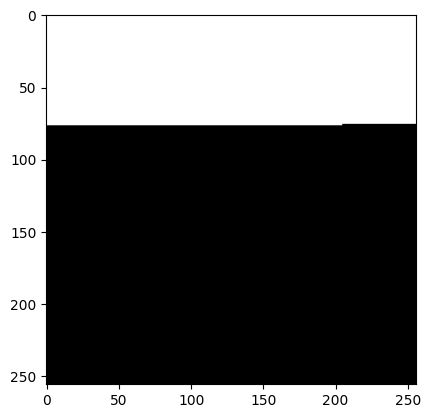

In [34]:
plt.imshow(pred_in_com_4_tmp, cmap = 'gray')

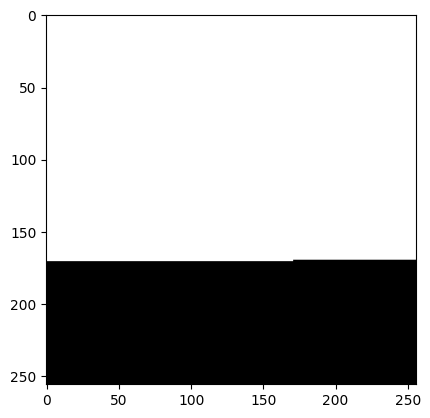

In [35]:
plt.imshow(pred_in_com_4_dsp, cmap = 'gray')

1/1 [==============================] - 0s 24ms/step


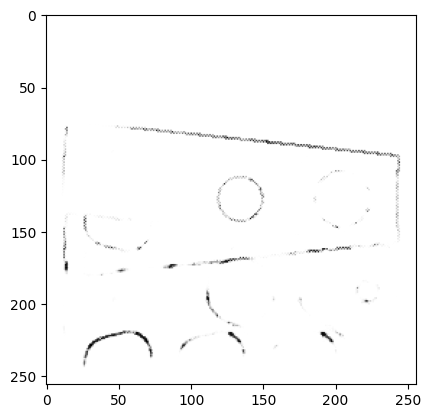

In [36]:
pred_in_com_4 = pred_in_com_4.reshape((1,256, 256, 2))

pred_out_com_4 = generator.predict(pred_in_com_4)

pred_out_com_4 = pred_out_com_4.reshape((256, 256))

plt.imshow(pred_out_com_4, cmap = 'gray')

In [37]:
pred_in_com_5_tmp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\tmp_test_input\tmp_test_com_5_in.png"
pred_in_com_5_dsp_path = r"C:\Hyundai GAN\hyundai_cgan_data\test_inputs\dsp_test_input\dsp_test_com_5_in.png"

pred_in_com_5_tmp = imread(pred_in_com_5_tmp_path)
pred_in_com_5_dsp = imread(pred_in_com_5_dsp_path)

pred_in_com_5_tmp = pred_in_com_5_tmp.reshape((256, 256, 1))
pred_in_com_5_dsp = pred_in_com_5_dsp.reshape((256, 256, 1))

pred_in_com_5 = np.concatenate((pred_in_com_5_tmp, pred_in_com_5_dsp), axis=2)

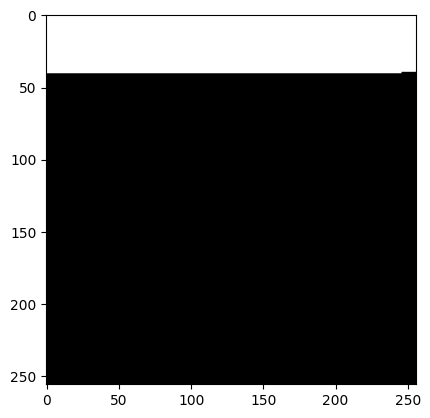

In [38]:
plt.imshow(pred_in_com_5_tmp, cmap = 'gray')

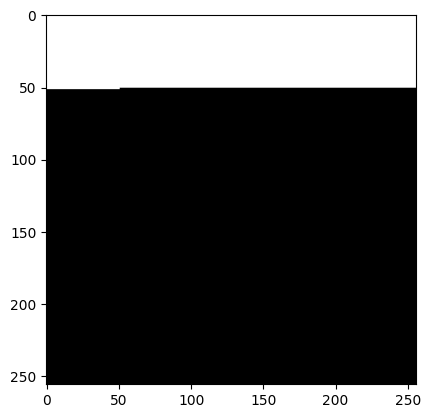

In [39]:
plt.imshow(pred_in_com_5_dsp, cmap = 'gray')

1/1 [==============================] - 0s 27ms/step


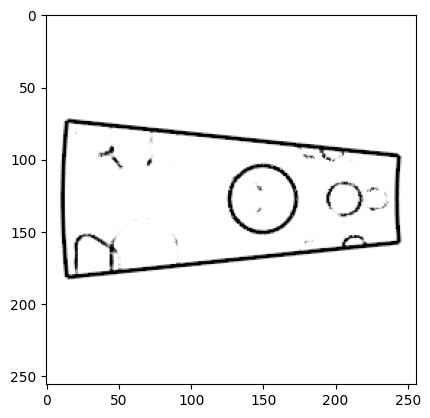

In [40]:
pred_in_com_5 = pred_in_com_5.reshape((1, 256, 256, 2))

pred_out_com_5 = generator.predict(pred_in_com_5)

pred_out_com_5 = pred_out_com_5.reshape((256, 256))

plt.imshow(pred_out_com_5, cmap = 'gray')

1/1 [==============================] - 0s 38ms/step


(-0.5, 255.5, 255.5, -0.5)

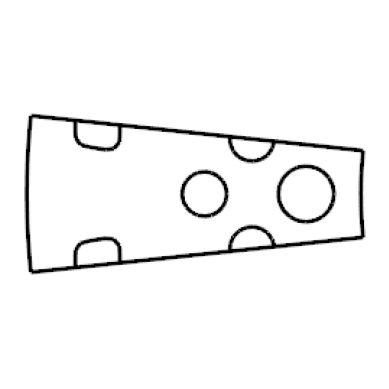

In [43]:
pred = generator.predict(train_data.take(1))
plt.imshow(pred[0],cmap='gray')
plt.axis(False)

In [100]:
x_te=tf.data.Dataset.from_tensor_slices(x_te)
y_te=tf.data.Dataset.from_tensor_slices(y_te)

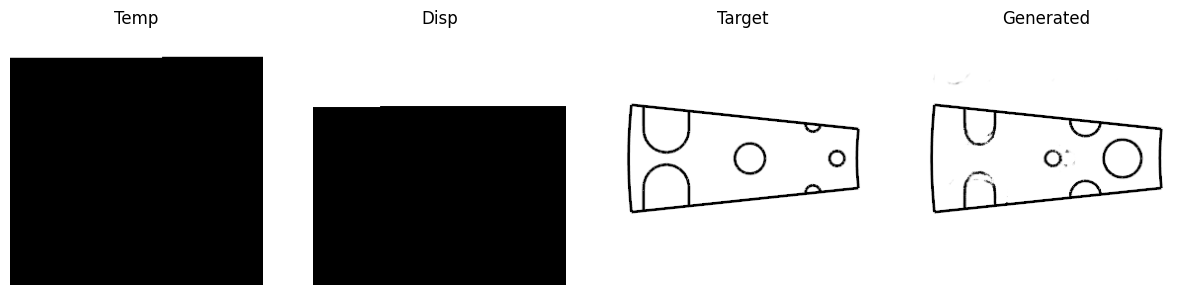

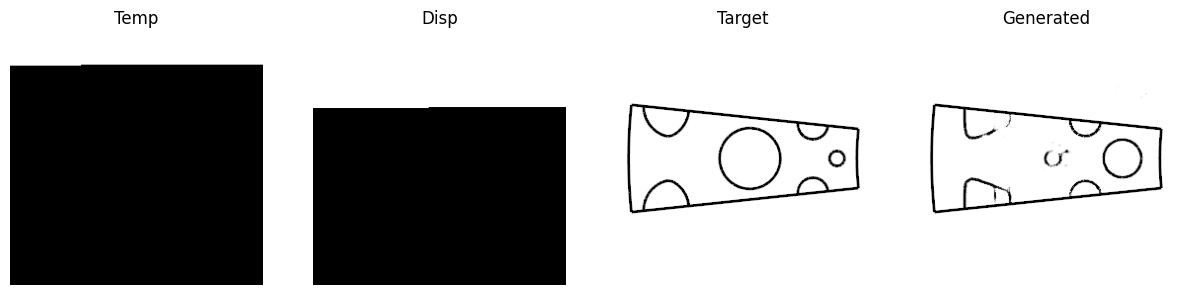

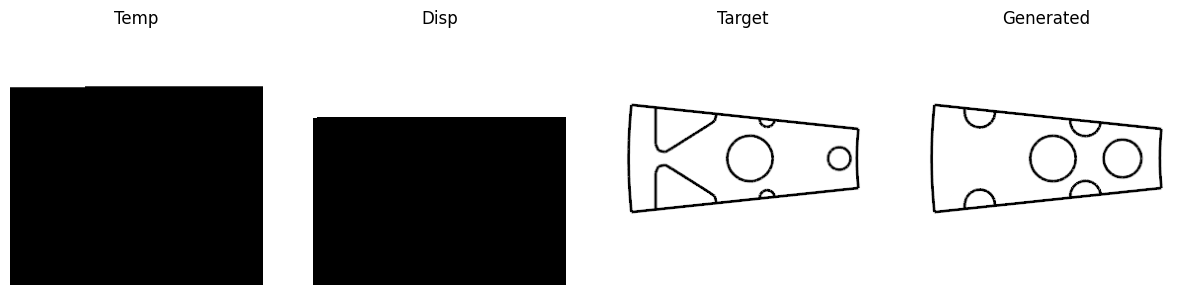

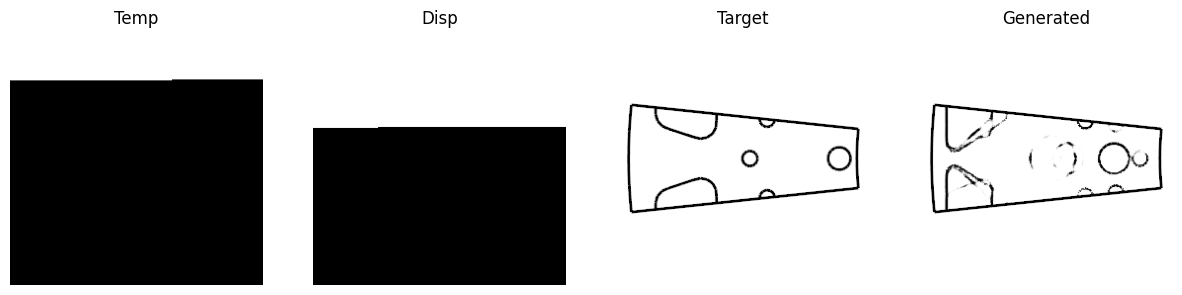

In [50]:
#TEST DATASET PLOTS
from IPython import display
for step,(x_,y_) in enumerate(tf.data.Dataset.zip((x_te,y_te))):
    display.display(display.HTML(f'<h3>Test Input {step+1}</h3>'))
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(x_[:,:,0],cmap='gray')
    plt.axis(False)
    plt.title('Temp')
    plt.subplot(1,4,2)
    plt.imshow(x_[:,:,1],cmap='gray')
    plt.axis(False)
    plt.title('Disp')
    plt.subplot(1,4,3)
    plt.imshow(y_,cmap='gray')
    plt.axis(False)
    plt.title('Target')
    plt.subplot(1,4,4)
    plt.imshow(generator(tf.expand_dims(x_,axis=0))[0],cmap='gray')
    plt.axis(False)
    plt.title('Generated')
    plt.savefig(f'plot_{step+1}.png')
    plt.show()

In [69]:

def get_images_var(tmp_elements,disp_elements,y_elements,size):
  X= np.zeros((size,256,256,2))
  Y= np.zeros((size,256,256,1))
  for index, (tmp_element, dsp_element) in enumerate(zip(tmp_elements, disp_elements)):
      # Load images for each channel
      tmp_element_path = os.path.join(x_test_tmp_folder_path, tmp_element)
      dsp_element_path = os.path.join(x_test_dsp_folder_path, dsp_element)
      img_tmp = imread(tmp_element_path)
      img_dsp = imread(dsp_element_path)

      # Reshape images for each channel
      img_tmp = img_tmp.reshape((256,256, 1))
      img_dsp = img_dsp.reshape((256,256, 1))

      # Combine channels
      img_combined = (np.concatenate((img_tmp, img_dsp), axis=2)-0.5)/0.5

      # Assign to X_train
      X[index] = img_combined

  # DEVELOPING Y_train MATRIX
  for index,Y_train_element in enumerate(y_elements):
      element_path = os.path.join(y_train_folder_path, Y_train_element)
      img = imread(element_path)
      img = np.mean(img, axis=2)
      img = img/127.5-1
      img = img.reshape((256, 256, 1))
      Y[index] = img
  return X,Y

x_test_tmp_folder_path = "C:/Hyundai GAN/hyundai_cgan_data/test_variations/temp_var/"
x_test_dsp_folder_path = "C:/Hyundai GAN/hyundai_cgan_data/test_variations/disp_var/"


x_test_tmp_elements = os.listdir(x_test_tmp_folder_path)
x_test_dsp_elements = os.listdir(x_test_dsp_folder_path)

In [70]:
x_test_dsp_elements,x_test_tmp_elements

(['cc_256_disp_cv_1_in.png',
  'cc_256_disp_cv_2_in.png',
  'cc_256_disp_cv_3_in.png',
  'cc_256_disp_cv_4_in.png'],
 ['cc_256_temp_cv_1_in.png',
  'cc_256_temp_cv_2_in.png',
  'cc_256_temp_cv_3_in.png',
  'cc_256_temp_cv_4_in.png'])

In [107]:
x_var,_=get_images_var(x_test_tmp_elements,x_test_dsp_elements,y_elements[16:],len(x_test_tmp_elements))
x_var.shape

(4, 256, 256, 2)

In [105]:
x_var=tf.data.Dataset.from_tensor_slices(x_var)

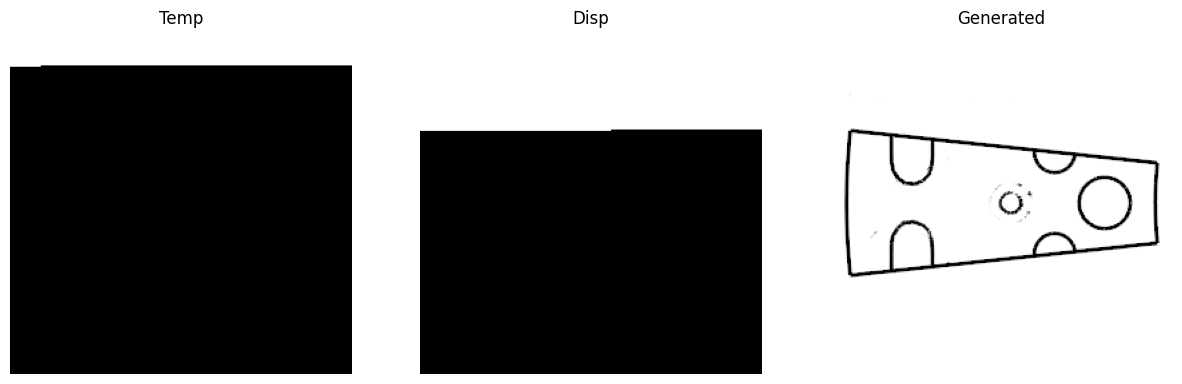

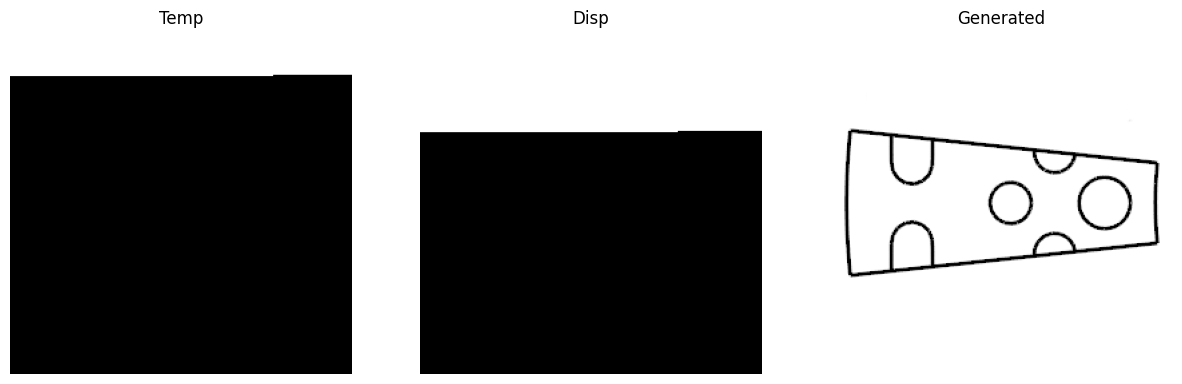

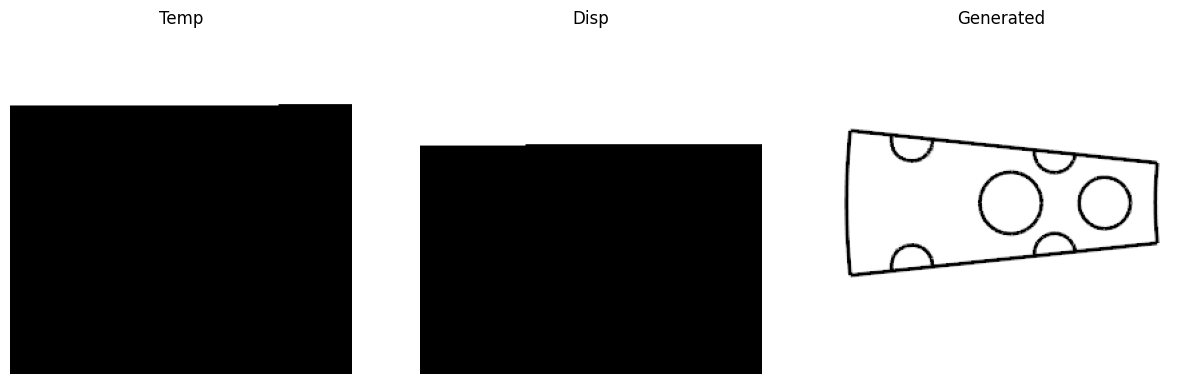

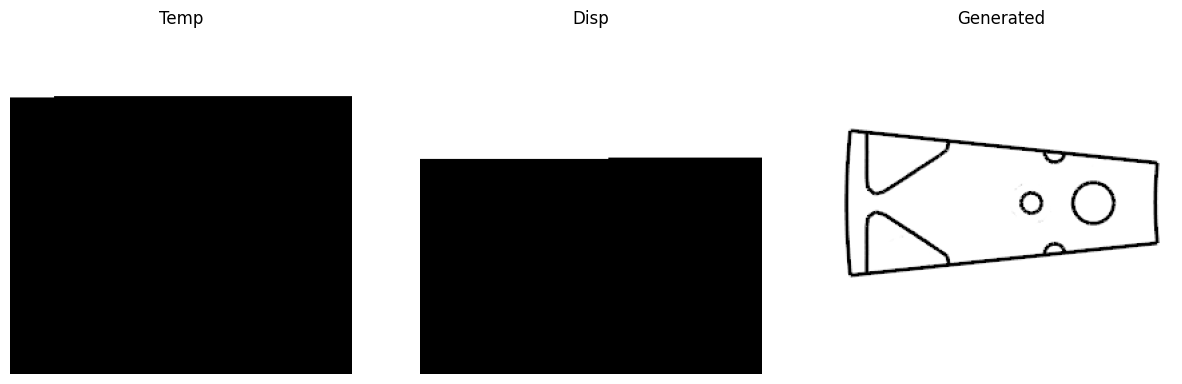

In [106]:
#PLOTS WITH INPUT VARIATION
from IPython import display
for step,(x_) in enumerate(tf.data.Dataset.zip((x_var))):
    display.display(display.HTML(f'<h3>Test Input {step+1}</h3>'))
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(x_[:,:,0],cmap='gray')
    plt.axis(False)
    plt.title('Temp')
    plt.subplot(1,3,2)
    plt.imshow(x_[:,:,1],cmap='gray')
    plt.axis(False)
    plt.title('Disp')
    plt.subplot(1,3,3)
    plt.imshow(generator(tf.expand_dims(x_,axis=0))[0],cmap='gray')
    plt.axis(False)
    plt.title('Generated')
    plt.savefig(f'variation_plot_{step+1}.png')
    plt.show()

In [108]:

x_te,y_te=get_images(x_tmp_elements[16:],x_dsp_elements[16:],y_elements[16:],len(x_tmp_elements[16:]))
x_te.shape,y_te.shape

((4, 256, 256, 2), (4, 256, 256, 1))

In [109]:
x_var_results=generator(x_var)
x_te_results=generator(x_te)

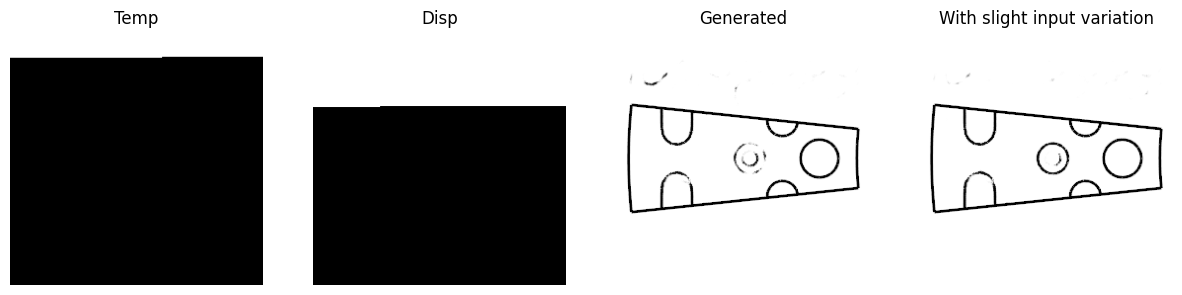

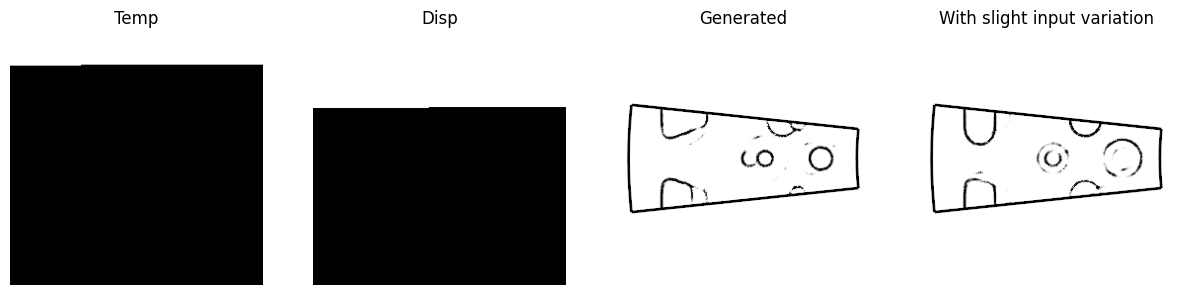

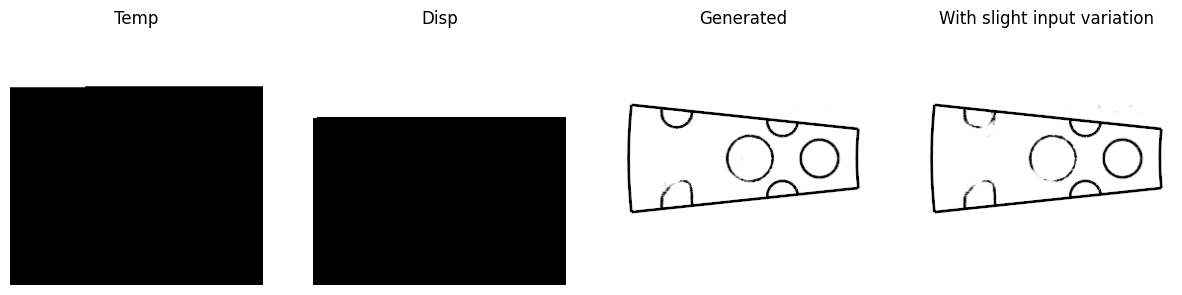

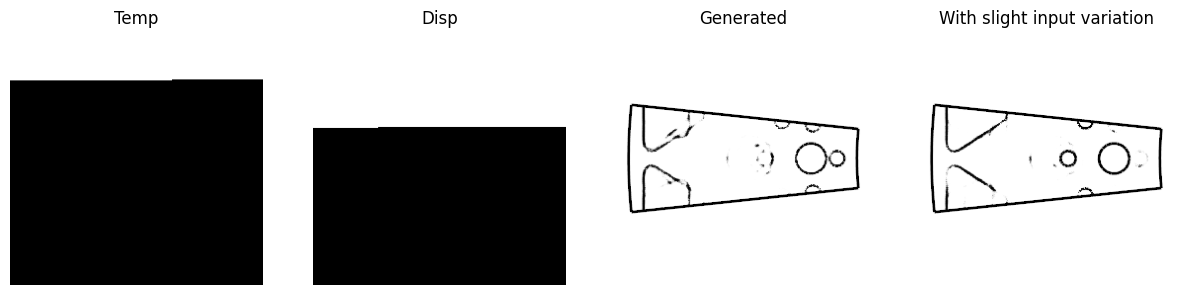

In [103]:
from IPython import display
for step,(x_,y_) in enumerate(tf.data.Dataset.zip((x_te,y_te))):
    display.display(display.HTML(f'<h3>Test Input {step+1}</h3>'))
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(x_[:,:,0],cmap='gray')
    plt.axis(False)
    plt.title('Temp')
    
    plt.subplot(1,4,2)
    plt.imshow(x_[:,:,1],cmap='gray')
    plt.axis(False)
    plt.title('Disp')
    
    plt.subplot(1,4,3)
    plt.imshow(x_te_results[step],cmap='gray')
    plt.axis(False)
    plt.title('Generated')
    
    plt.subplot(1,4,4)
    plt.imshow(x_var_results[step],cmap='gray')
    plt.axis(False)
    plt.title('With slight input variation')
    plt.savefig(f'comparison_plot_{step+1}.png')
    plt.show()